In [7]:
import polars as pl
import glob

files = sorted(glob.glob("players-csv/*_players.csv"))
print("files:", len(files))
print("sample:", files[:5])

NEEDED_COLS = ["mode", "stage", "weapon", "team", "win"]

df = (
    pl.scan_csv(
        files,
        infer_schema_length=200,
        ignore_errors=True,
    )
    .select([c for c in NEEDED_COLS])
    .collect(streaming=True)
)

print("rows:", df.height)
df.head()


files: 1188
sample: ['players-csv/2022-09-26_players.csv', 'players-csv/2022-09-27_players.csv', 'players-csv/2022-09-28_players.csv', 'players-csv/2022-09-29_players.csv', 'players-csv/2022-09-30_players.csv']


/var/folders/0c/mxy1q43d1jxg480rc319w3qr0000gn/T/ipykernel_50472/3808894652.py:17: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True)


rows: 39319880


shape: (5, 5)
┌────────┬─────────┬────────────────┬───────┬───────┐
│ mode   ┆ stage   ┆ weapon         ┆ team  ┆ win   │
│ ---    ┆ ---     ┆ ---            ┆ ---   ┆ ---   │
│ str    ┆ str     ┆ str            ┆ str   ┆ str   │
╞════════╪═════════╪════════════════╪═══════╪═══════╡
│ yagura ┆ chozame ┆ sshooter       ┆ alpha ┆ alpha │
│ yagura ┆ chozame ┆ campingshelter ┆ alpha ┆ alpha │
│ yagura ┆ chozame ┆ variableroller ┆ alpha ┆ alpha │
│ yagura ┆ chozame ┆ 52gal          ┆ alpha ┆ alpha │
│ yagura ┆ chozame ┆ nautilus47     ┆ bravo ┆ alpha │
└────────┴─────────┴────────────────┴───────┴───────┘

In [8]:
STAGE_API = "https://stat.ink/api/v3/stage"
WEAPON_API = "https://stat.ink/api/v3/weapon"

def fetch_json(url: str):
    with urlopen(url) as r:
        return json.loads(r.read().decode("utf-8"))

stages = fetch_json(STAGE_API)
weapons = fetch_json(WEAPON_API)

stage_ja = {s["key"]: s["name"].get("ja_JP", s["key"]) for s in stages}
weapon_ja = {w["key"]: w["name"].get("ja_JP", w["key"]) for w in weapons}

list(stage_ja.items())[:5], list(weapon_ja.items())[:5]

([('yunohana', 'ユノハナ大渓谷'),
  ('gonzui', 'ゴンズイ地区'),
  ('kinmedai', 'キンメダイ美術館'),
  ('mategai', 'マテガイ放水路'),
  ('namero', 'ナメロウ金属')],
 [('52gal', '.52ガロン'),
  ('52gal_deco', '.52ガロンデコ'),
  ('96gal', '.96ガロン'),
  ('96gal_deco', '.96ガロンデコ'),
  ('96gal_sou', '.96ガロン爪')])

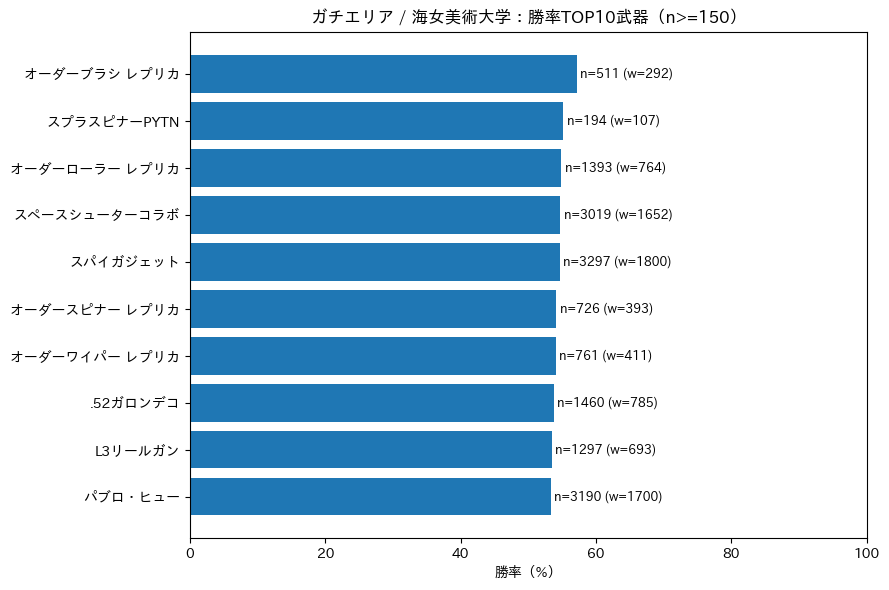

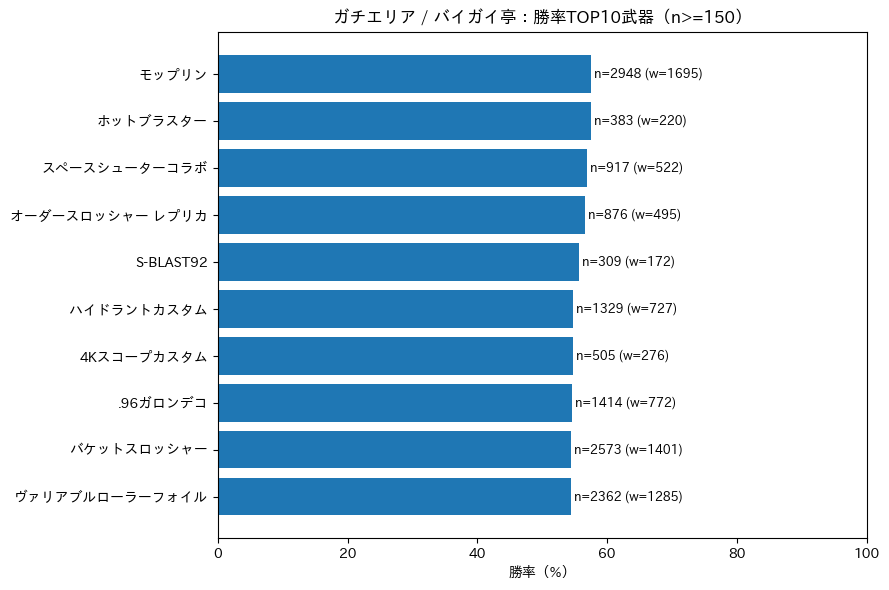

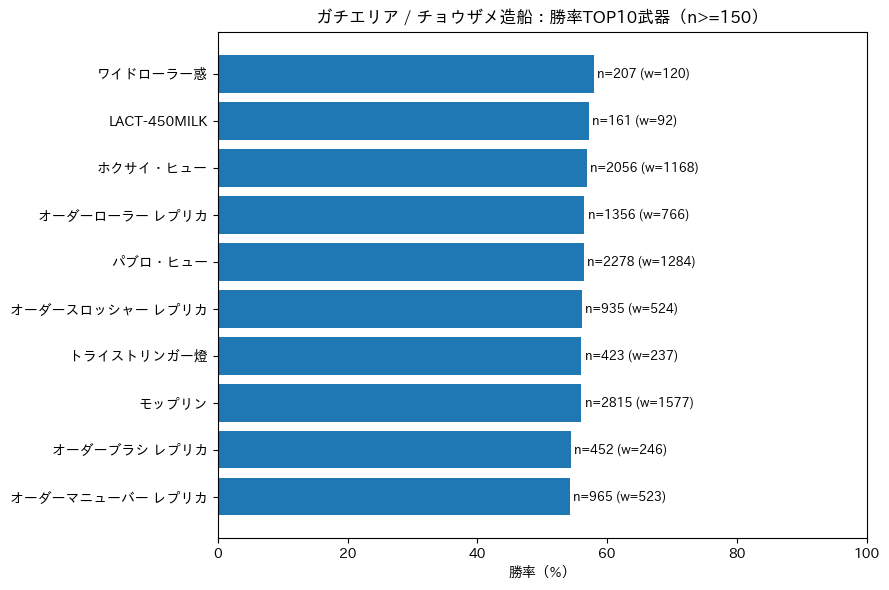

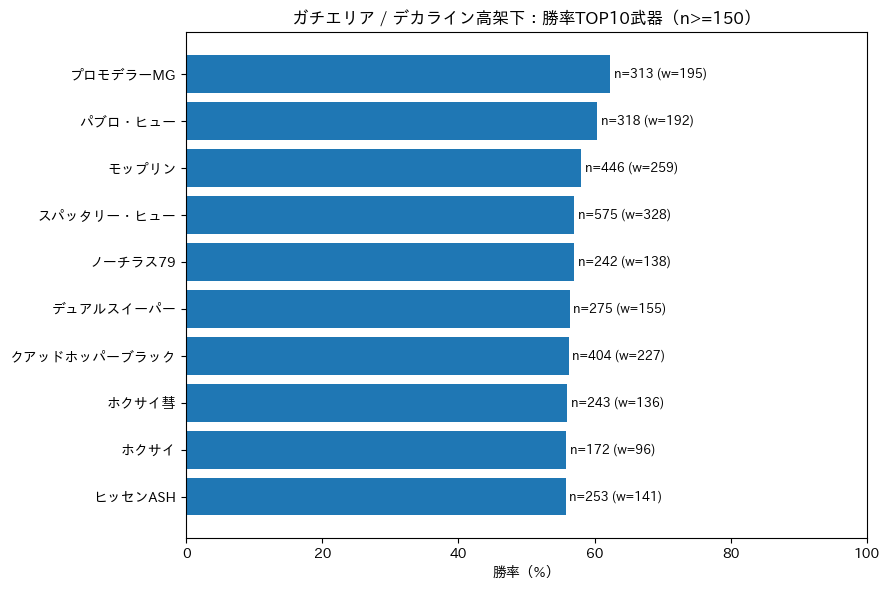

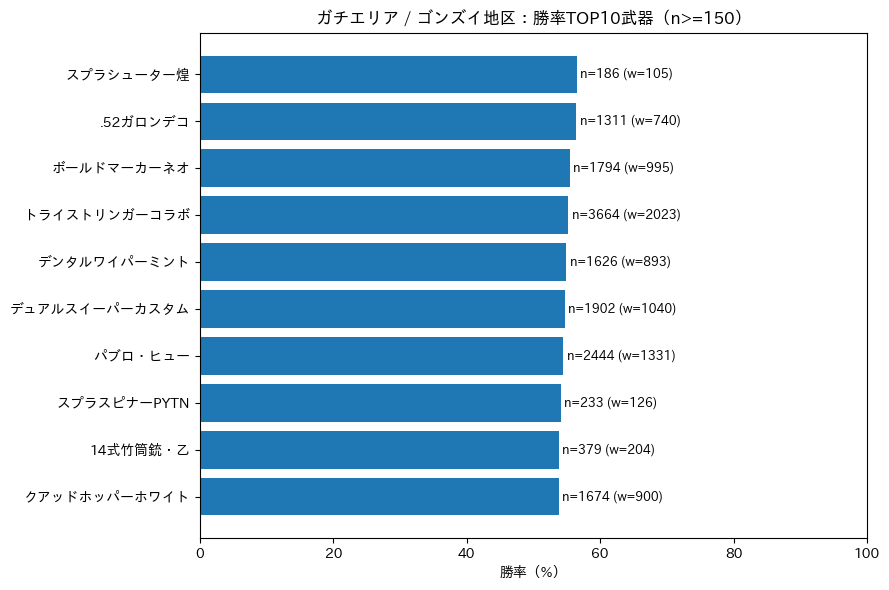

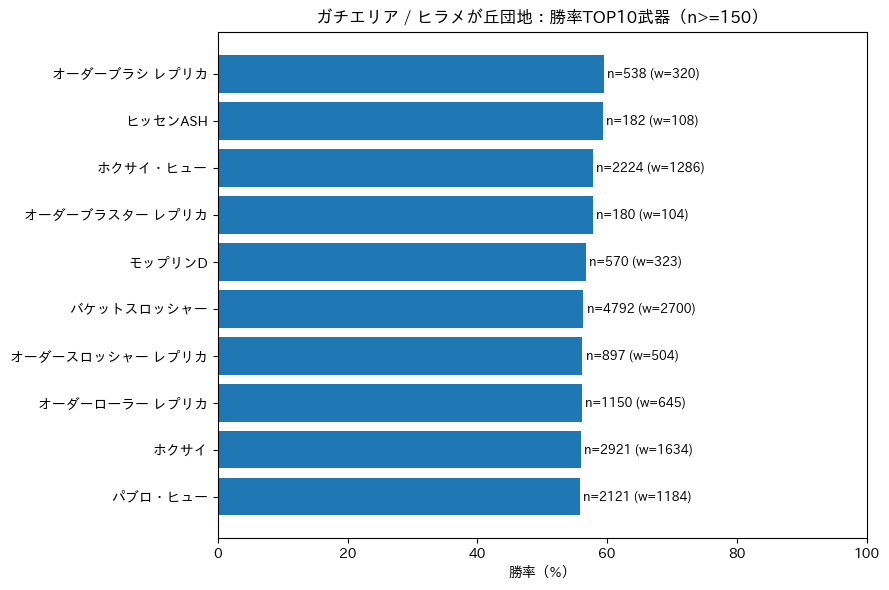

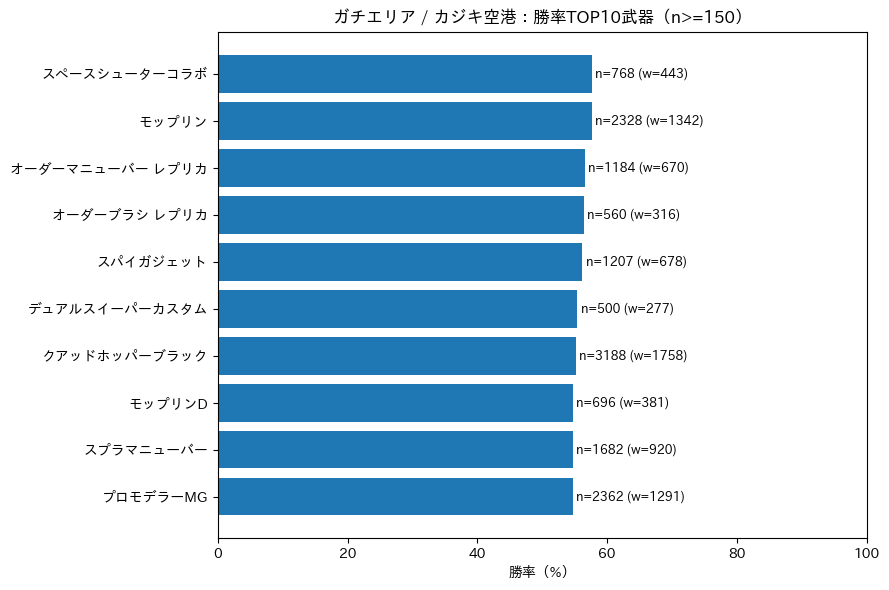

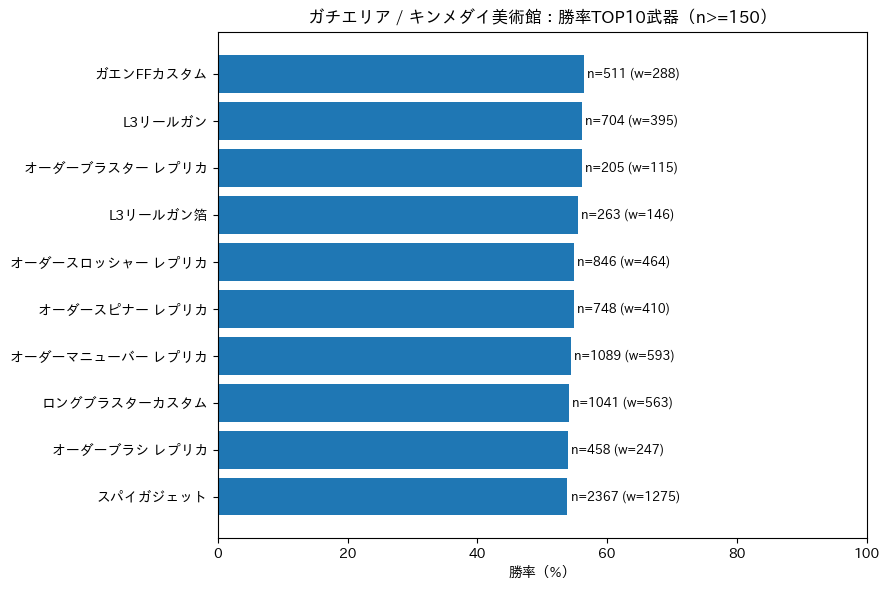

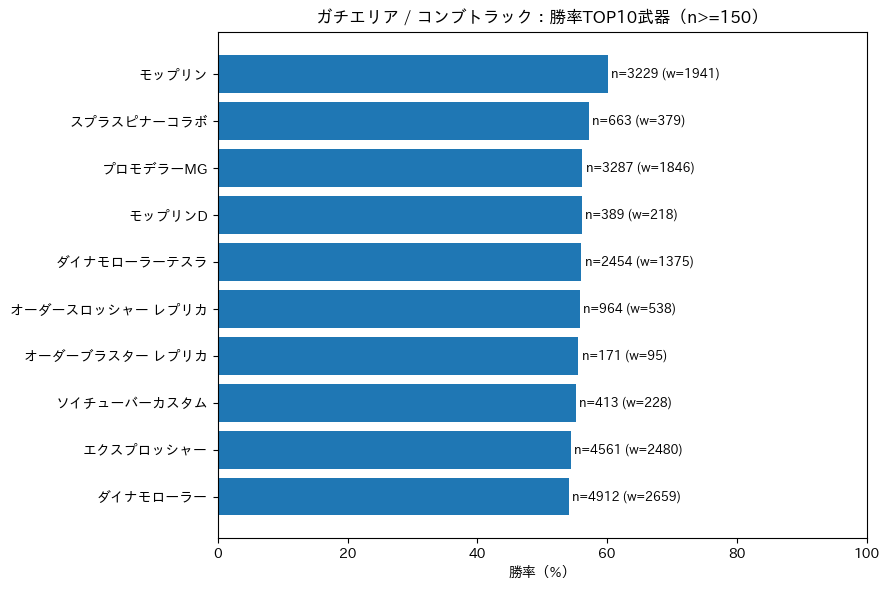

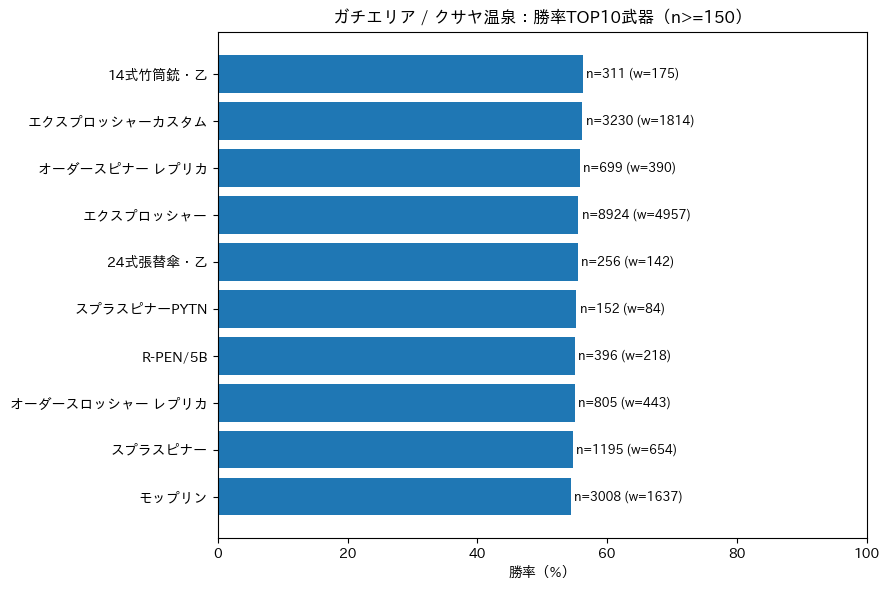

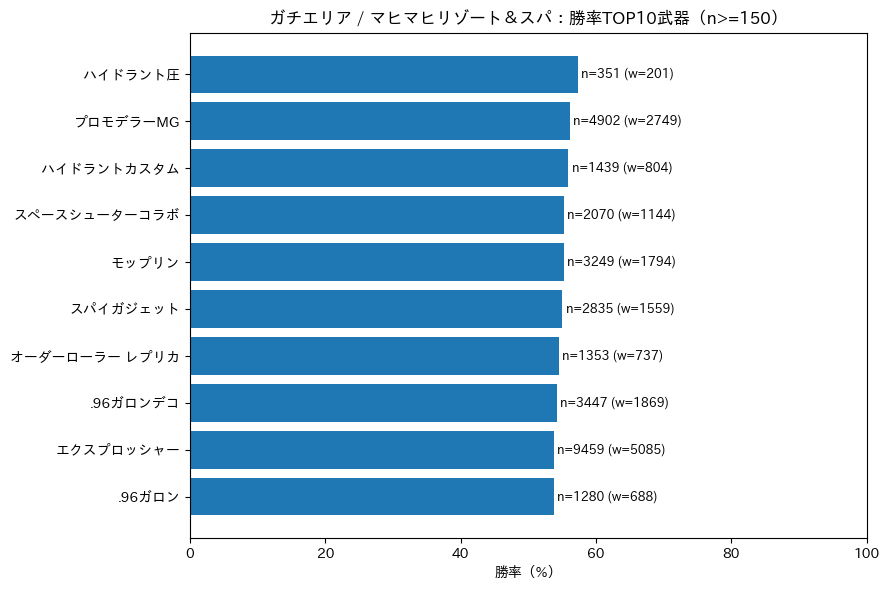

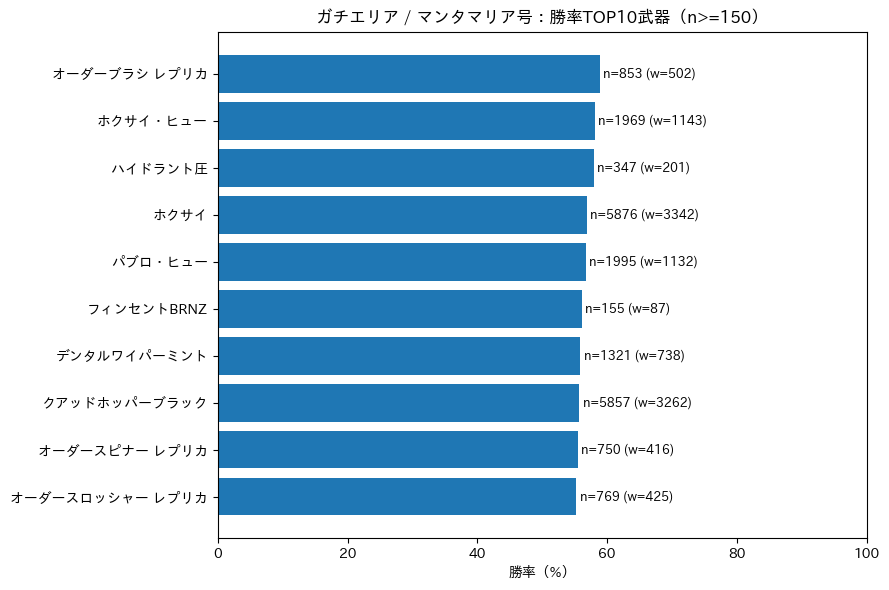

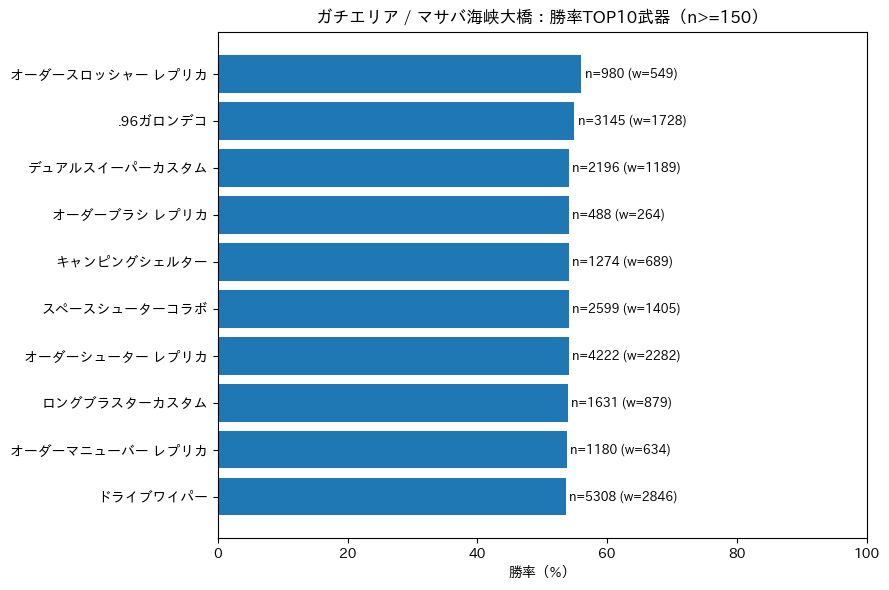

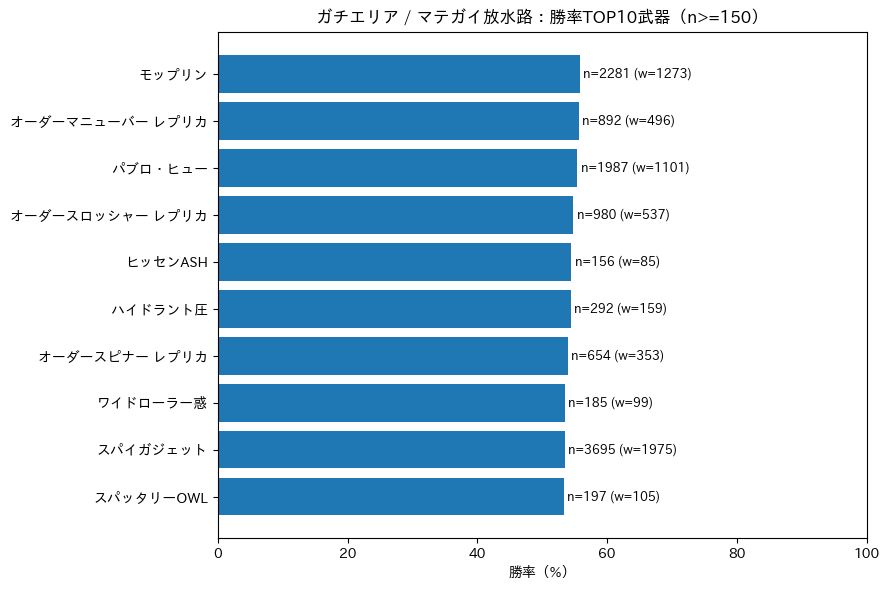

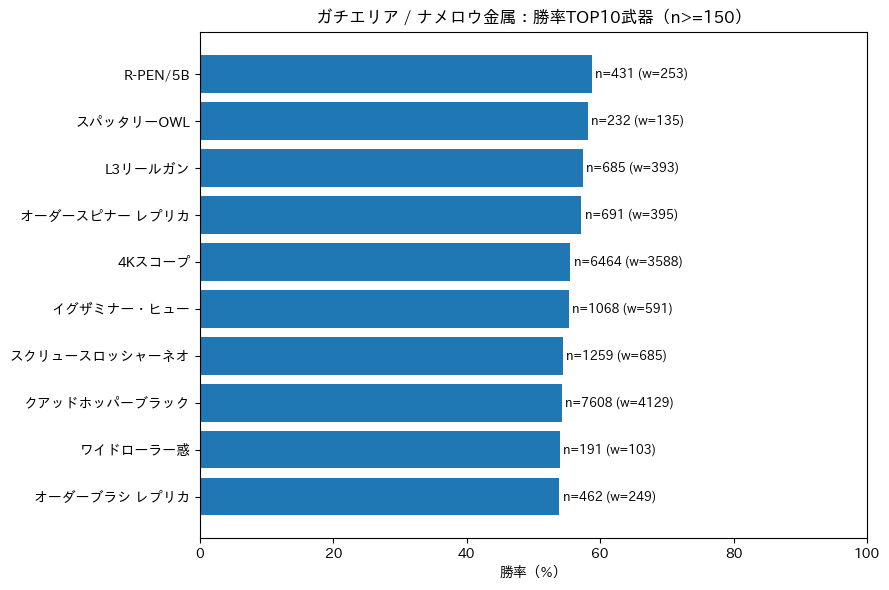

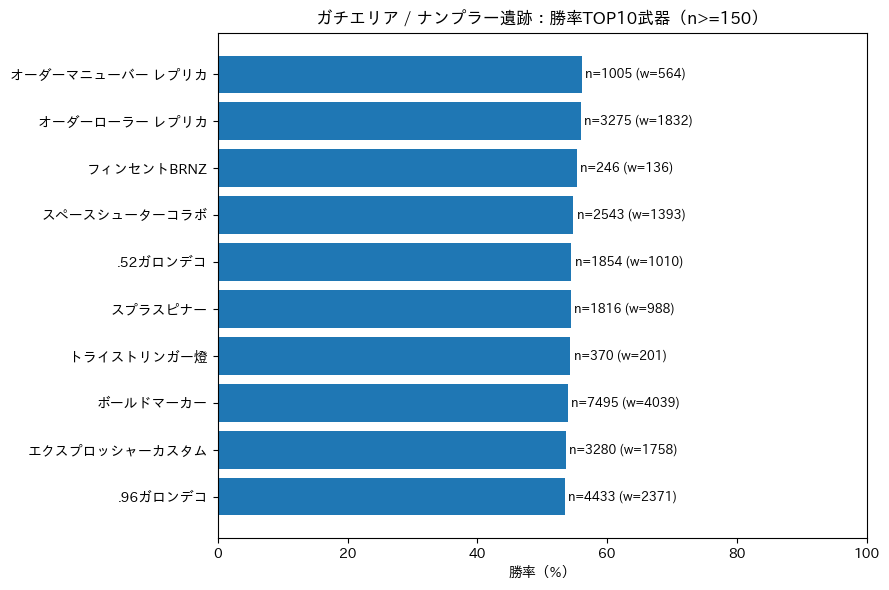

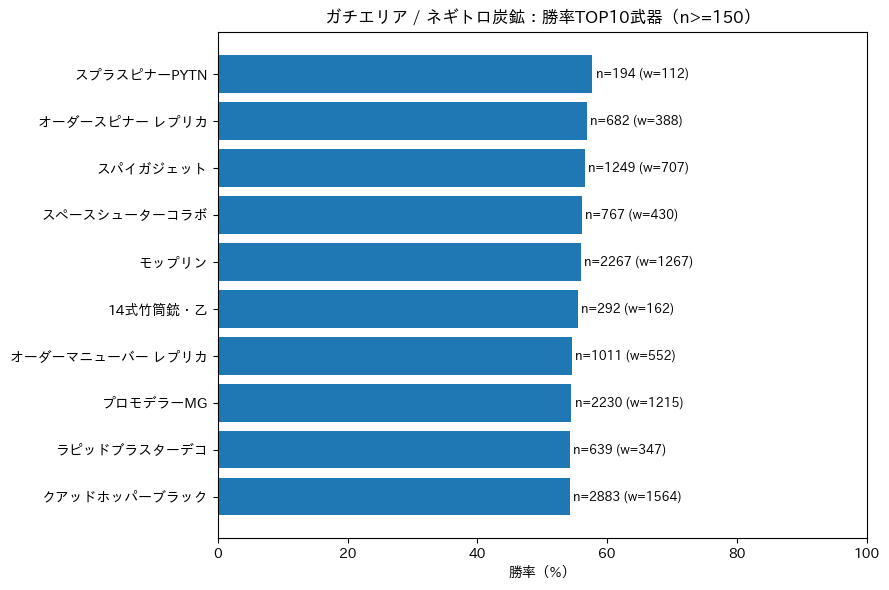

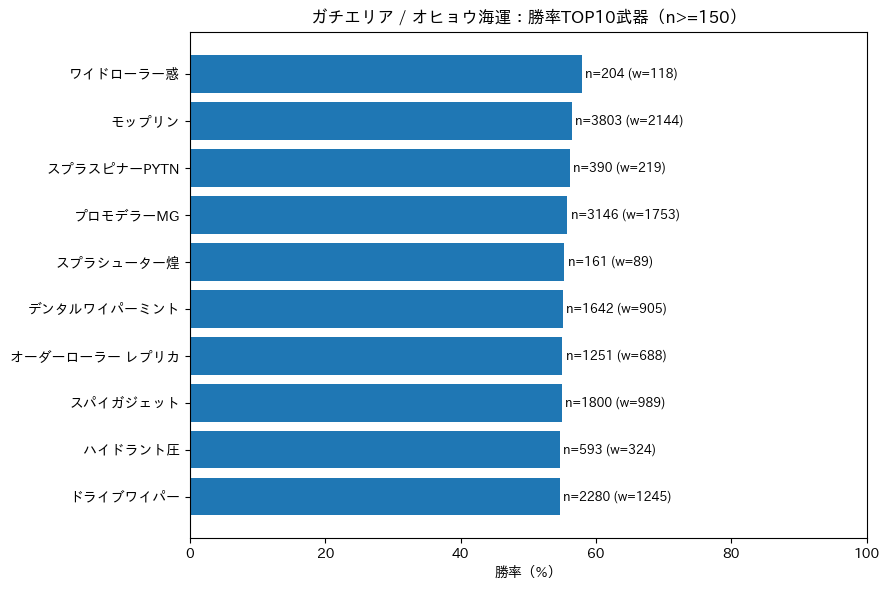

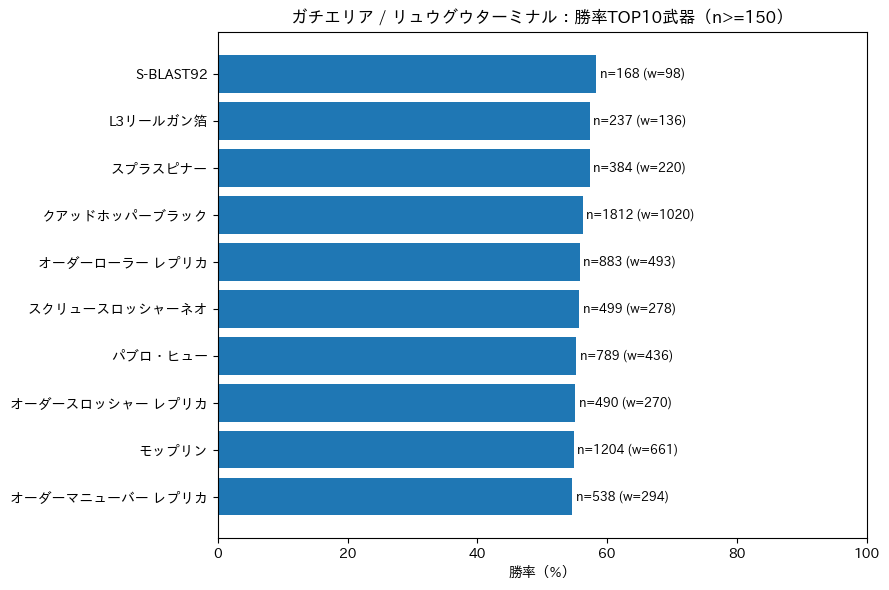

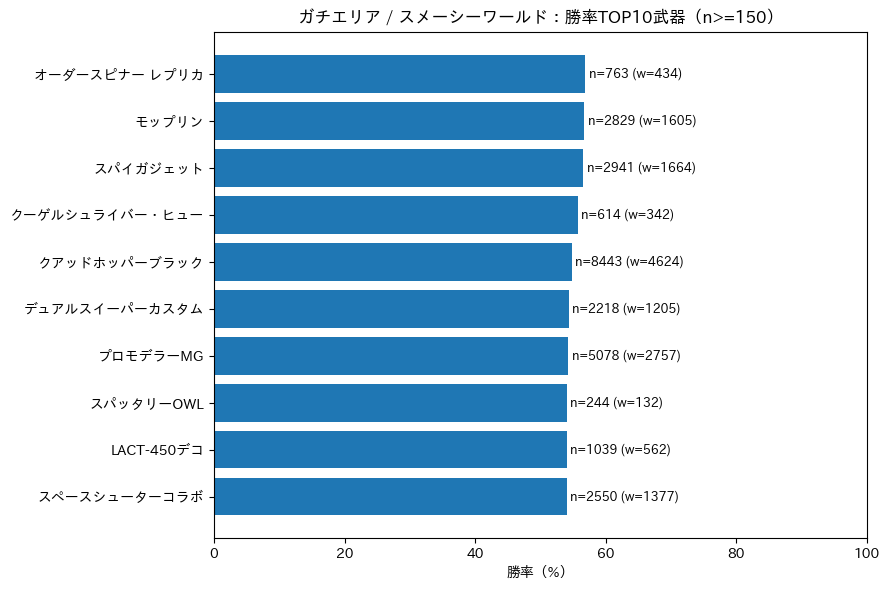

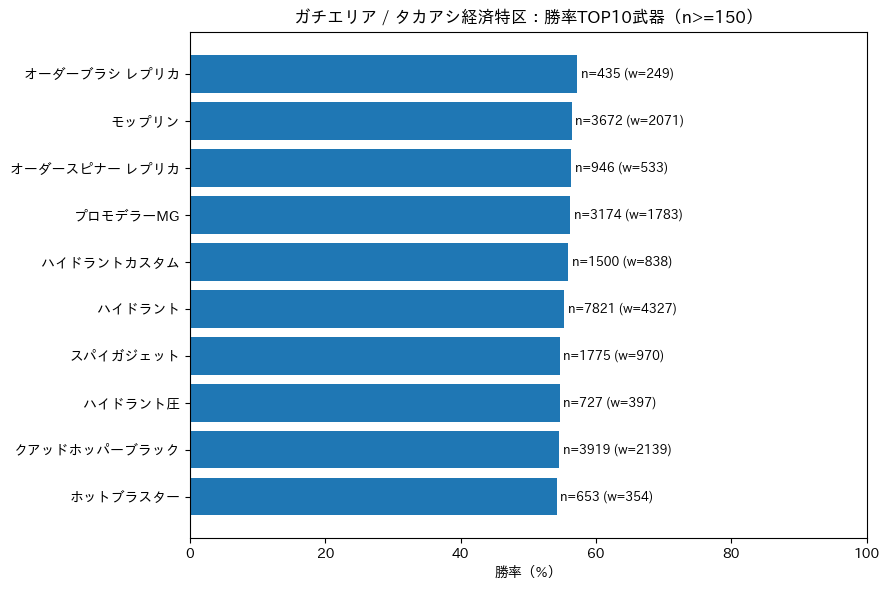

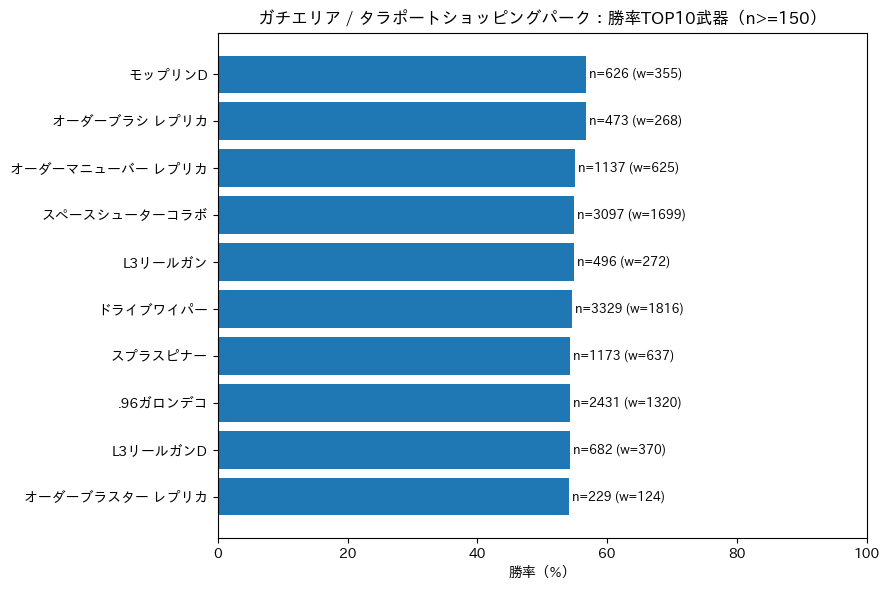

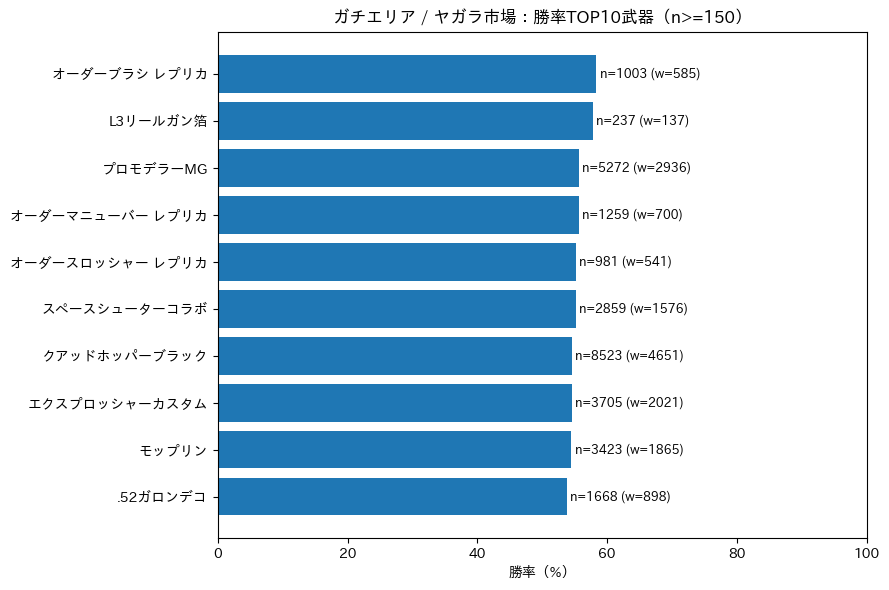

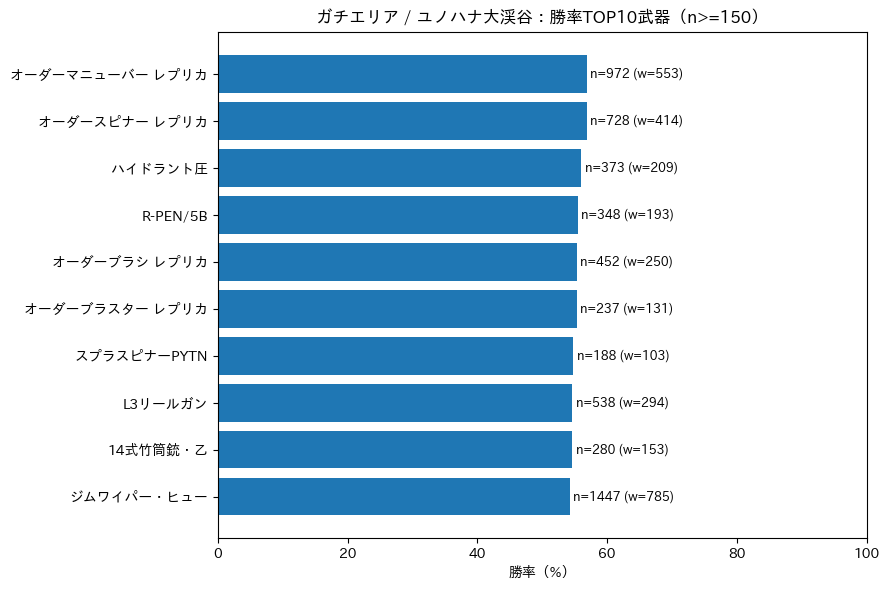

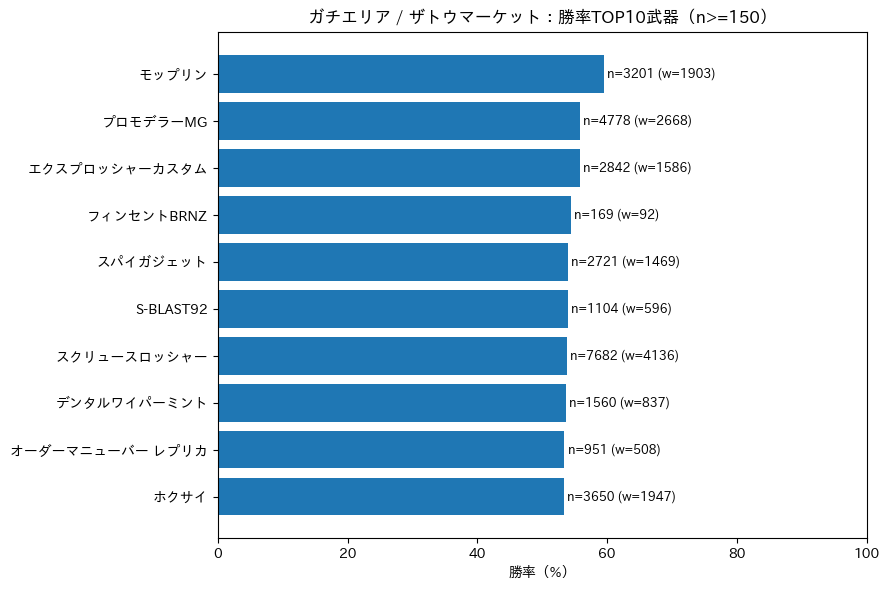

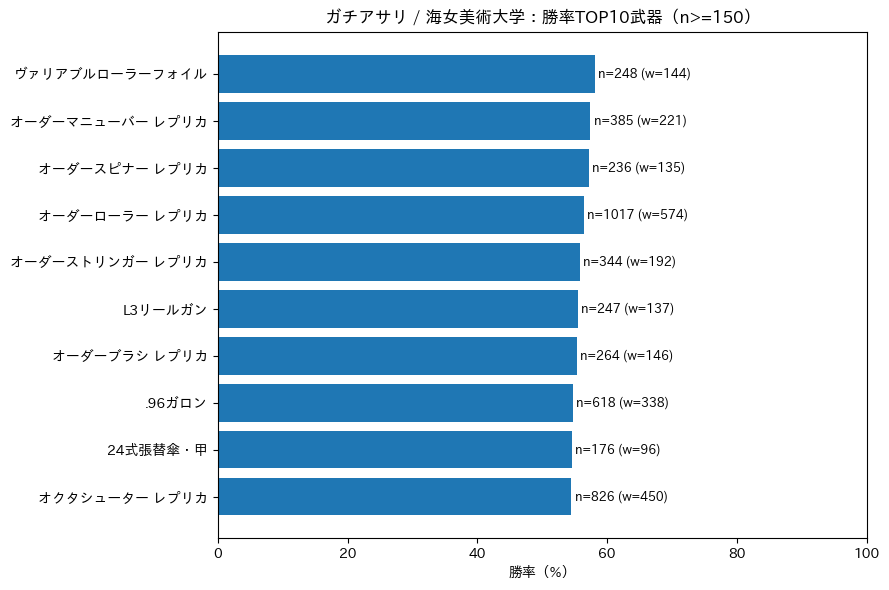

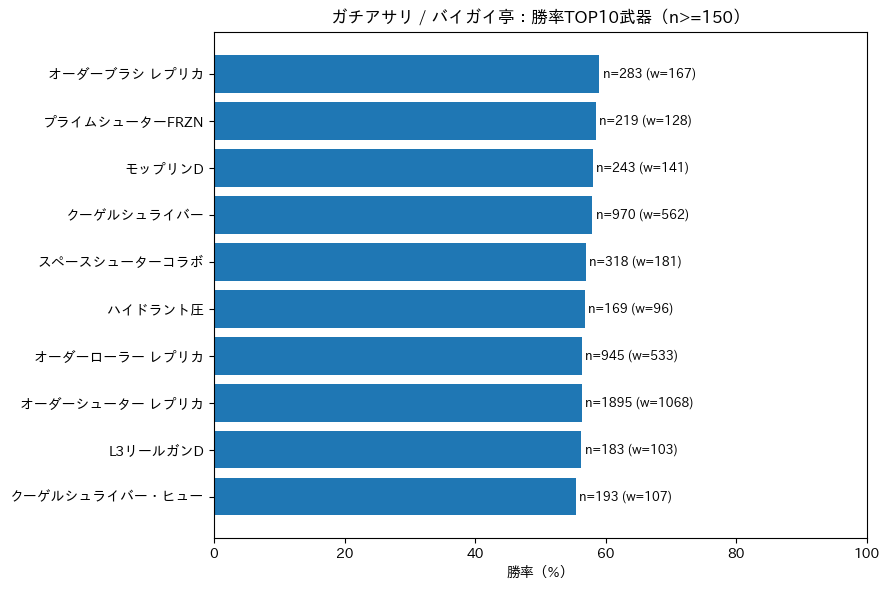

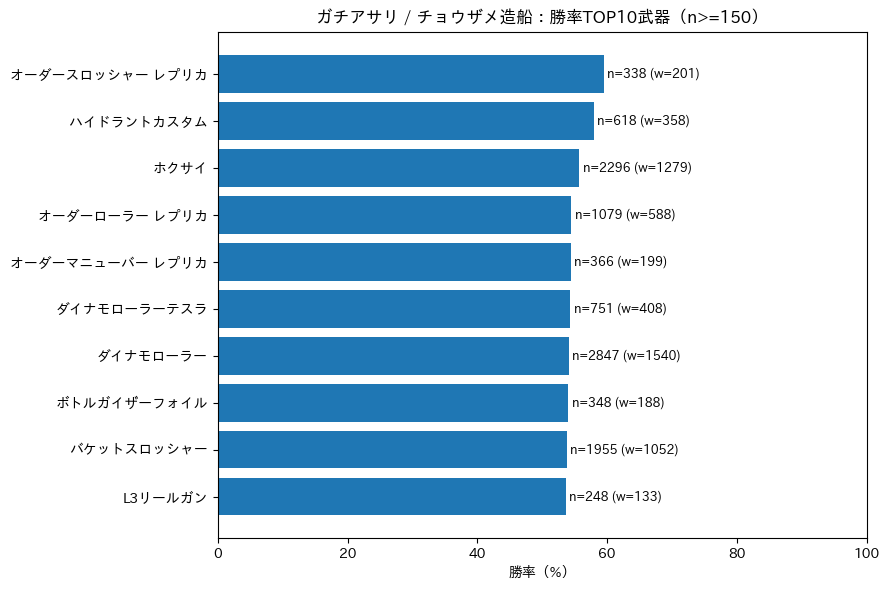

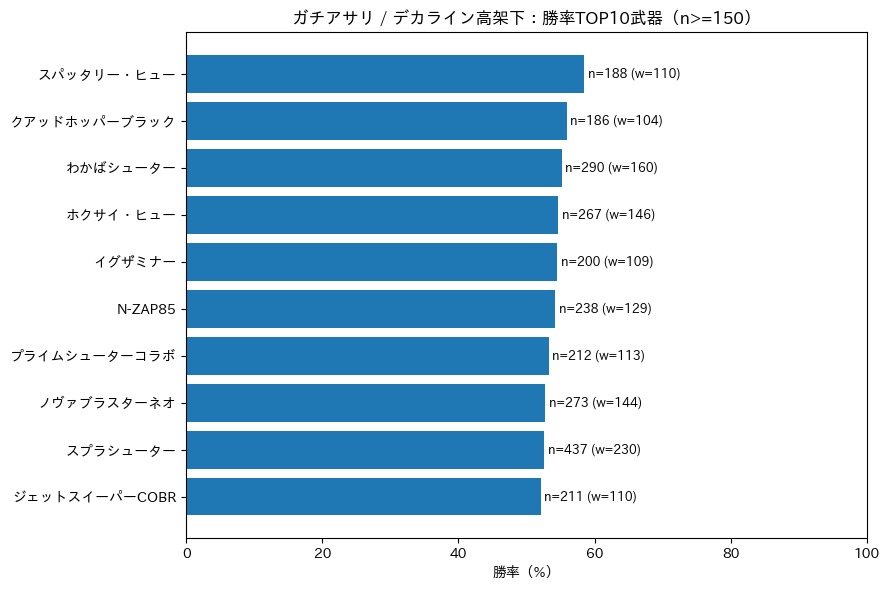

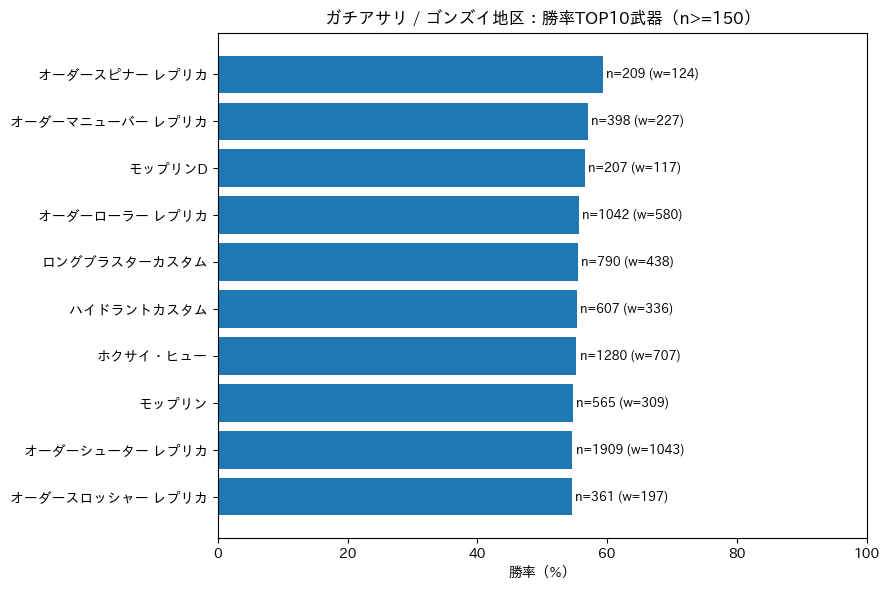

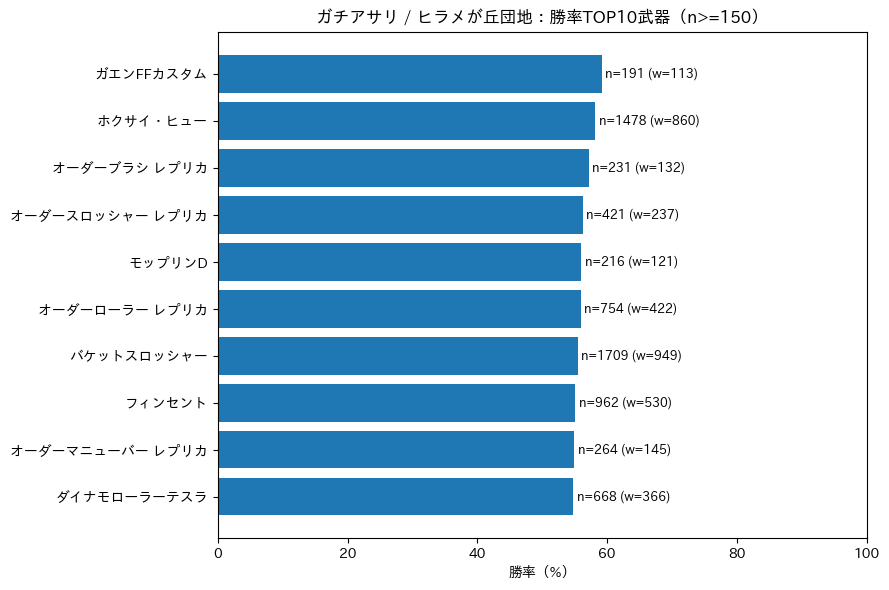

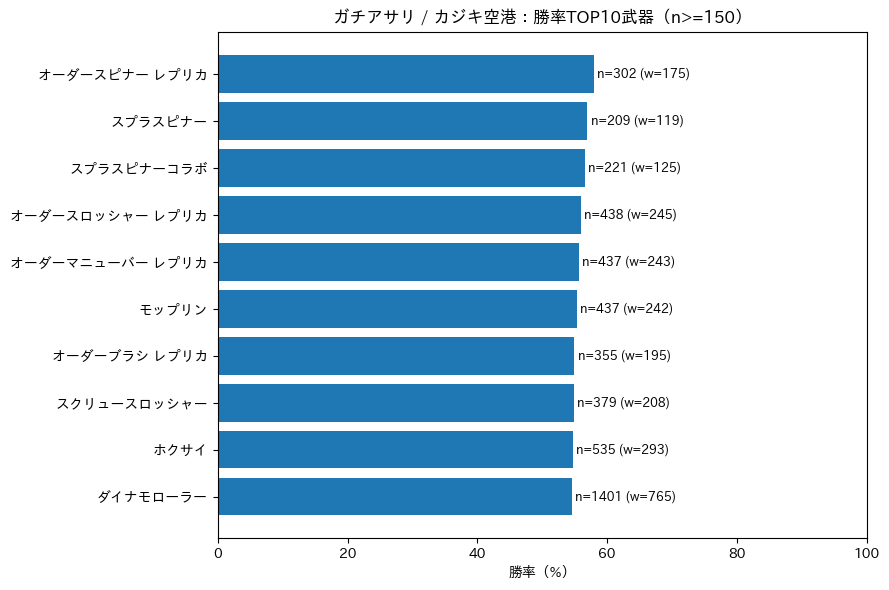

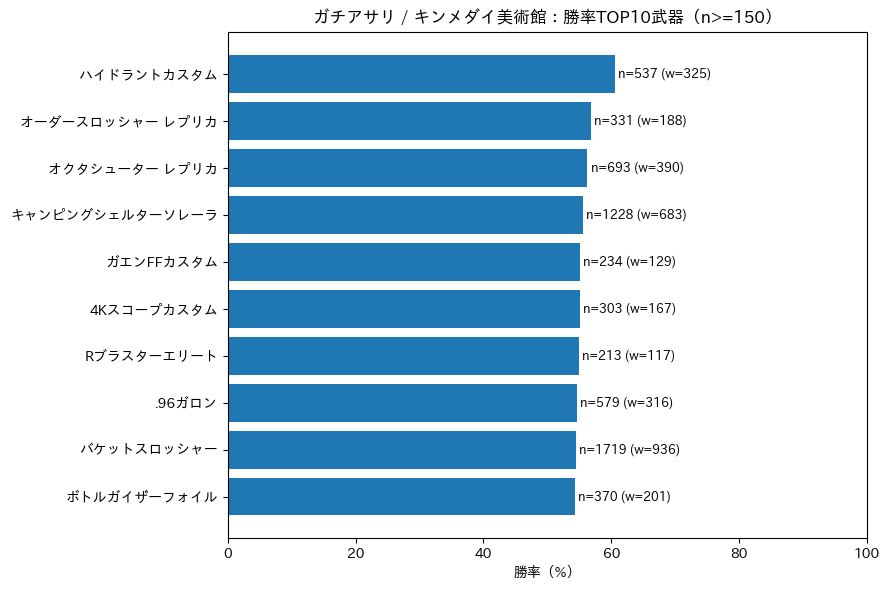

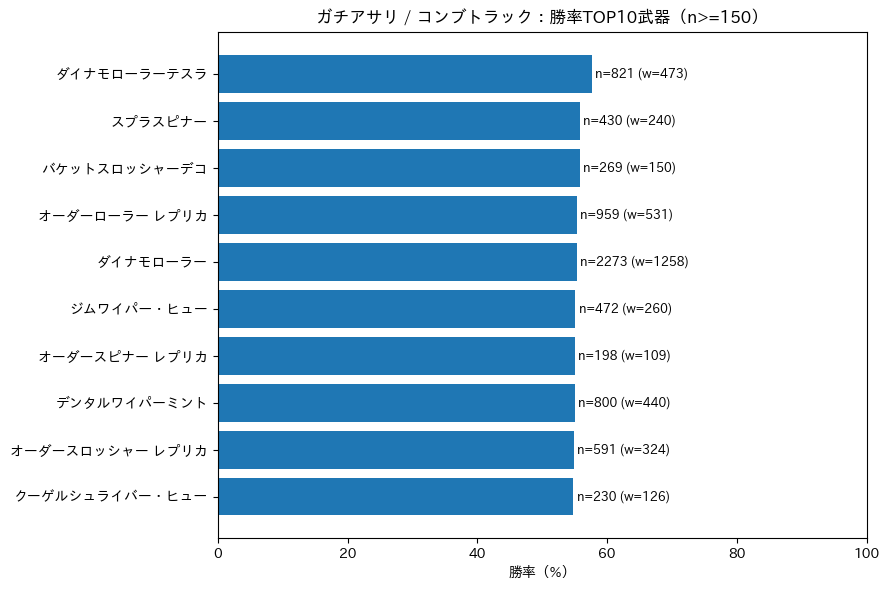

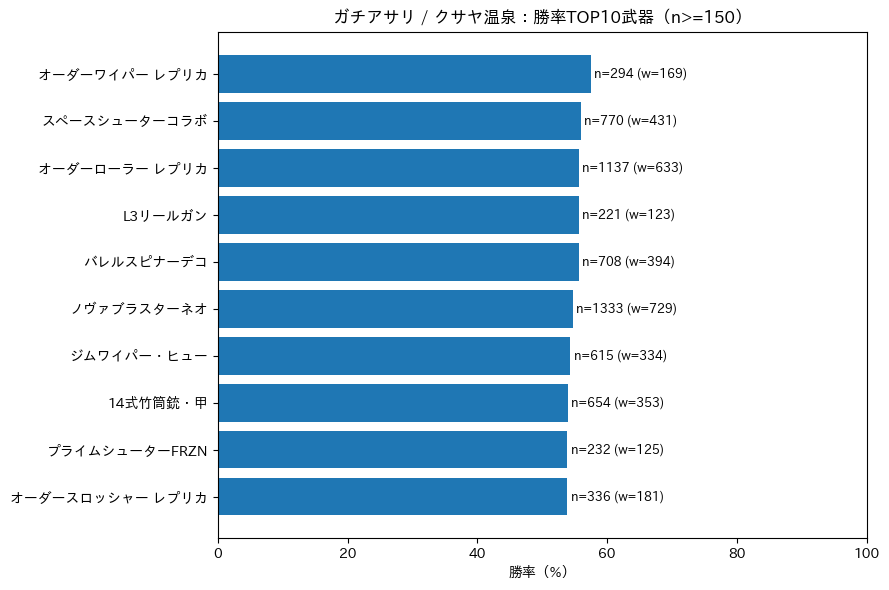

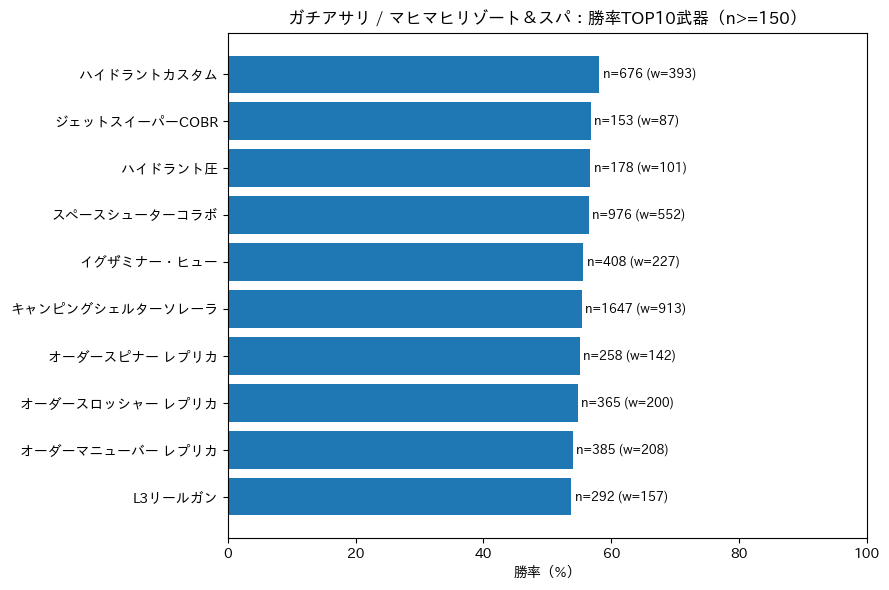

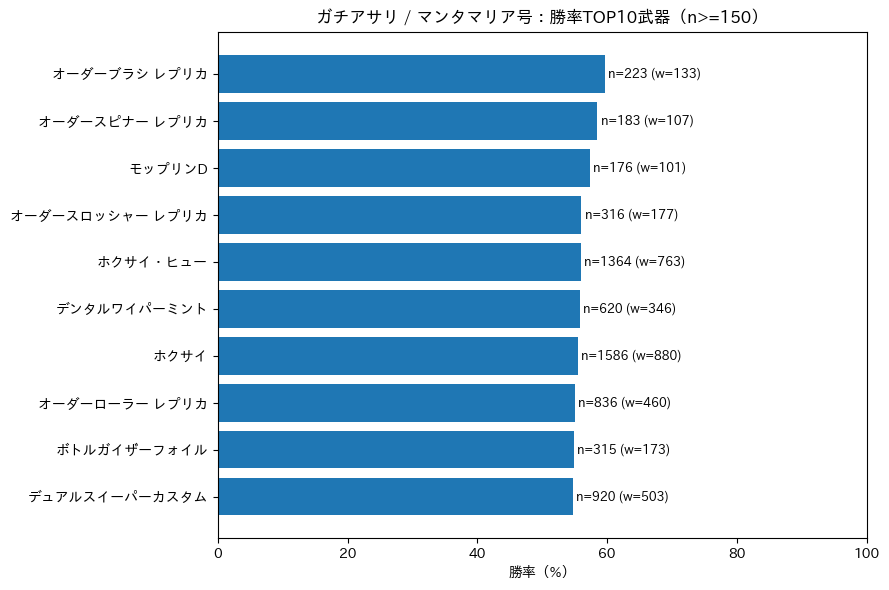

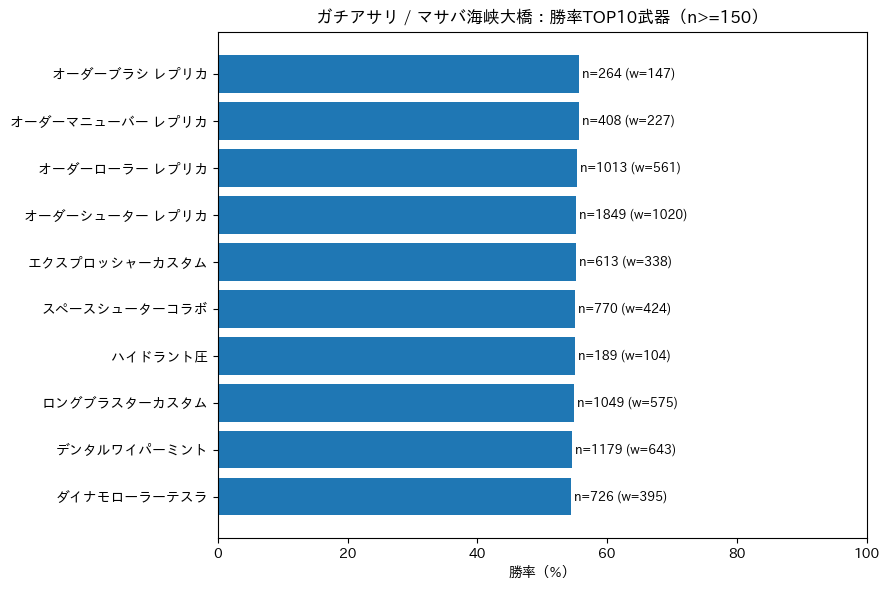

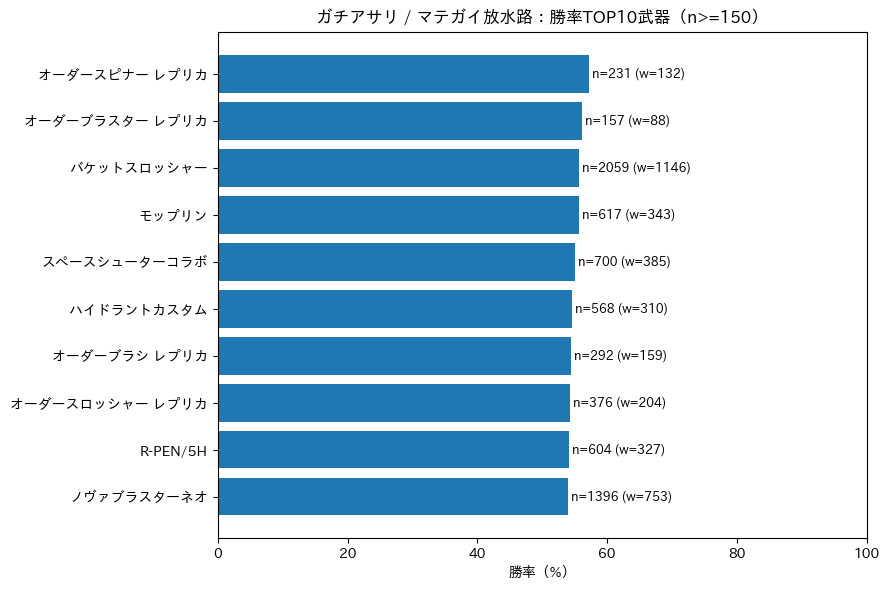

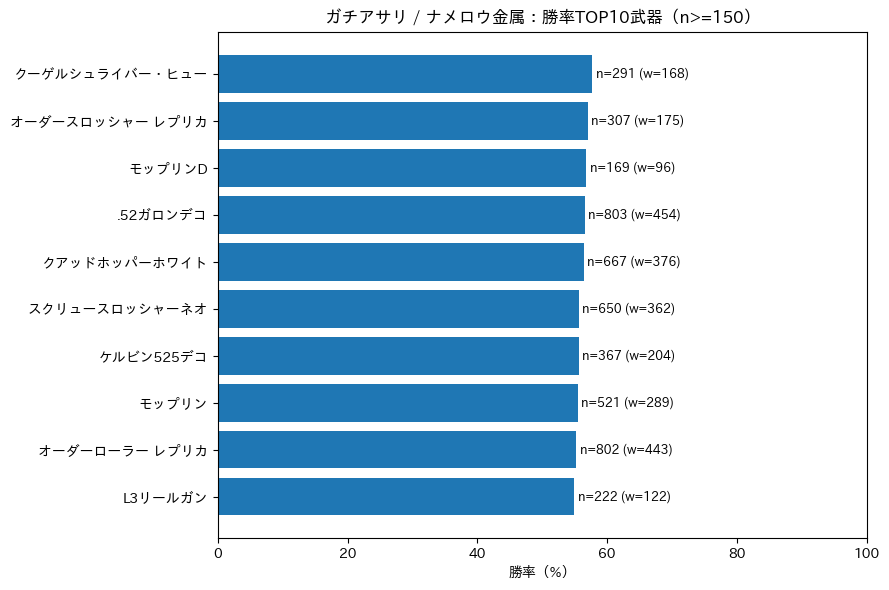

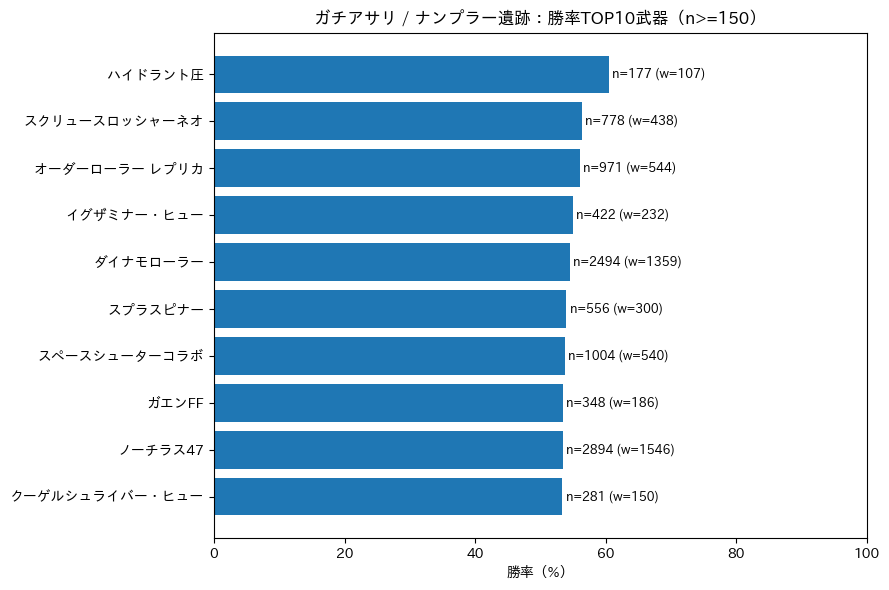

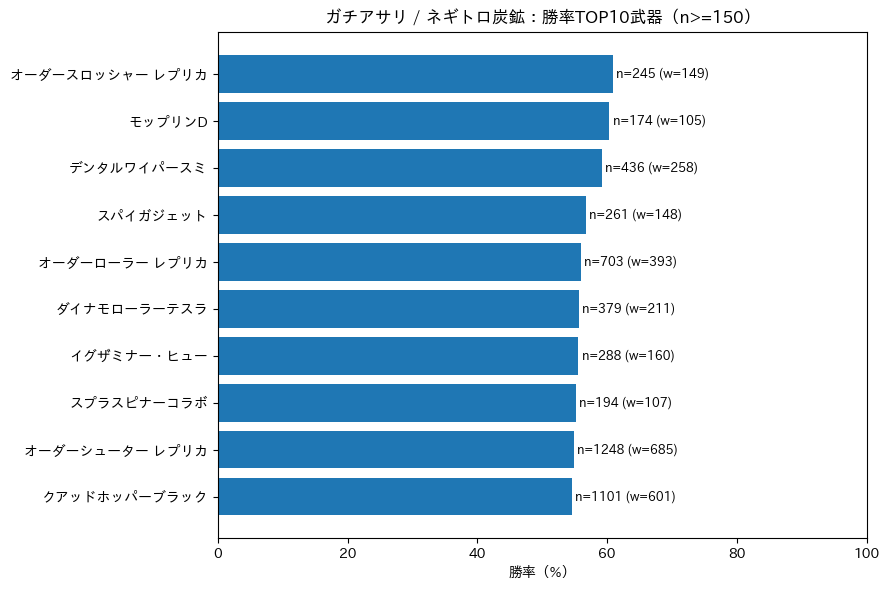

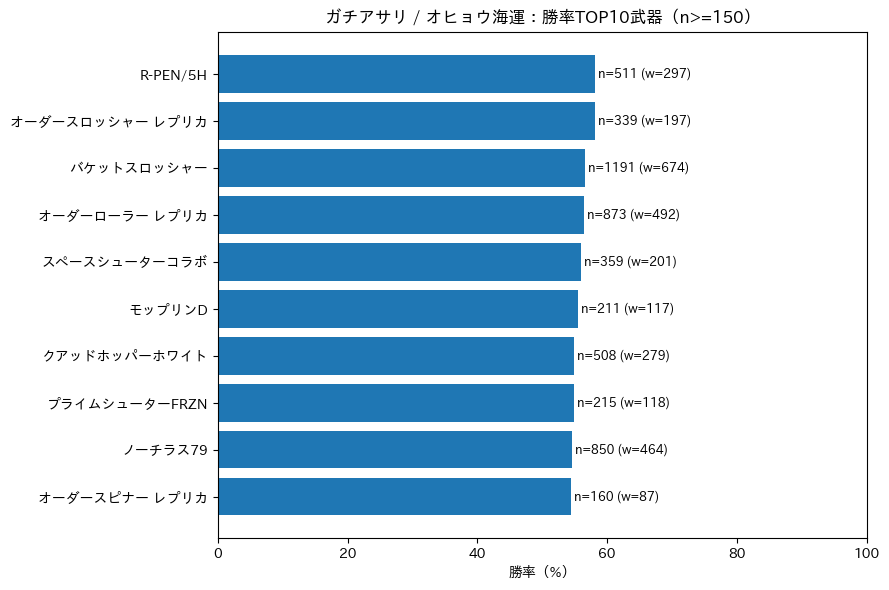

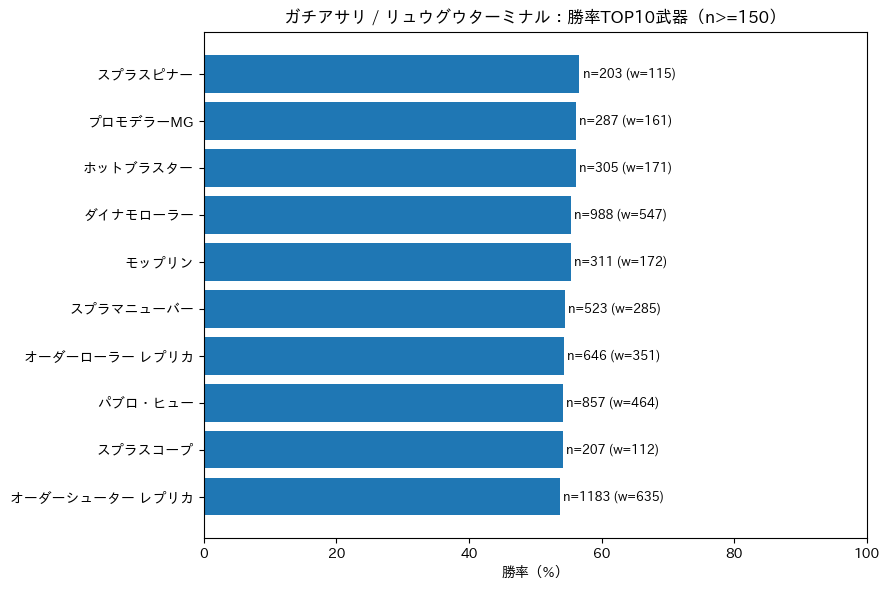

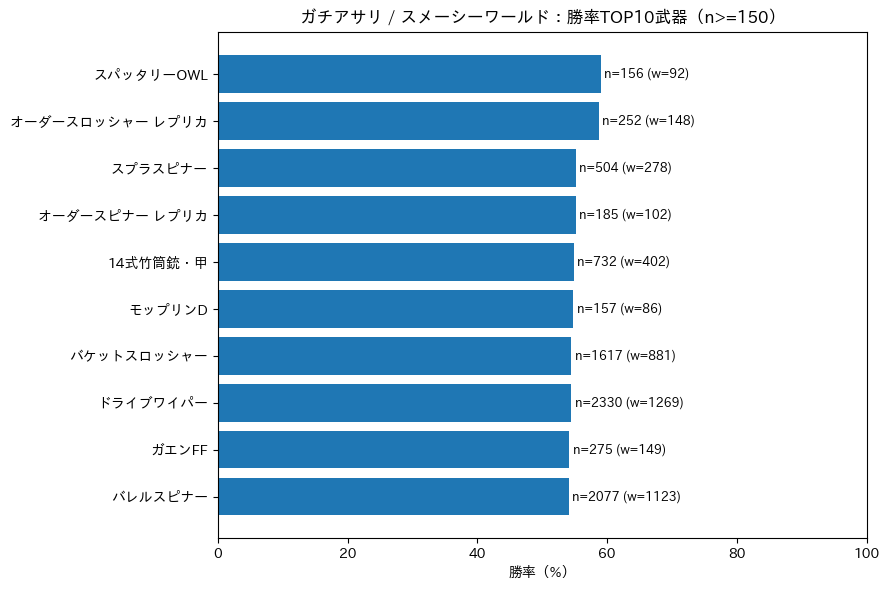

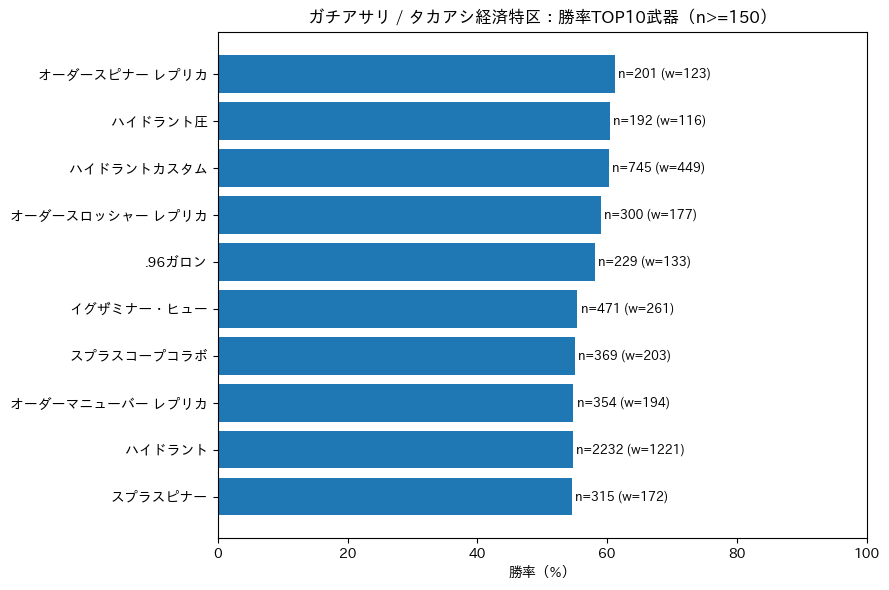

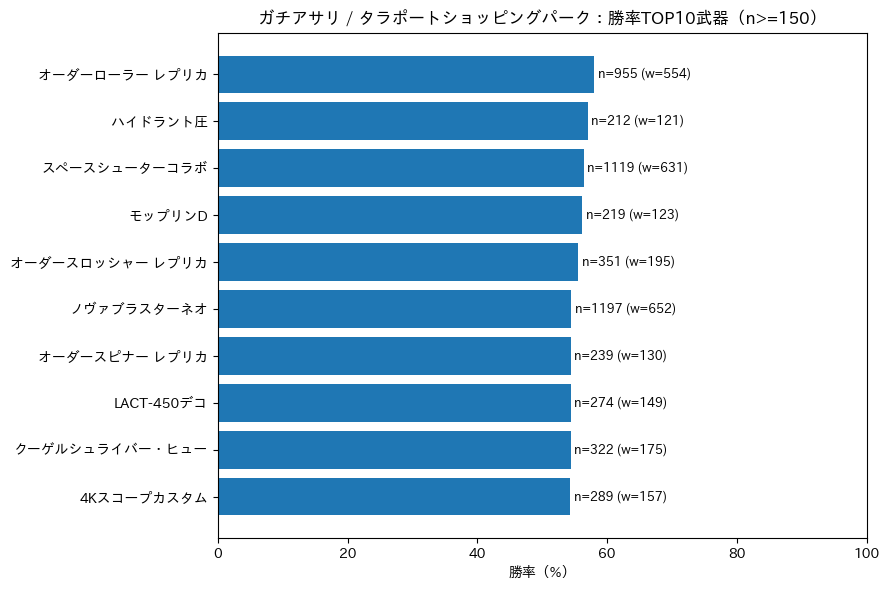

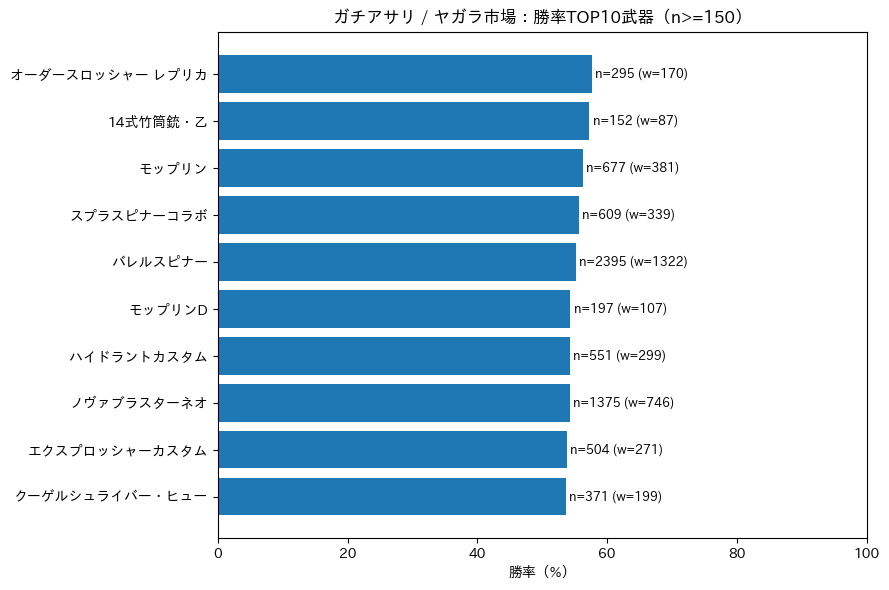

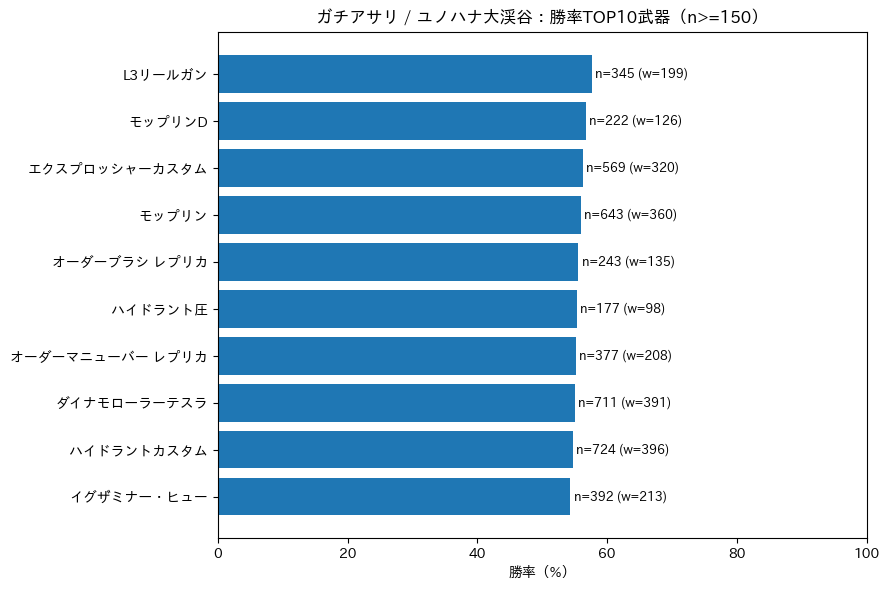

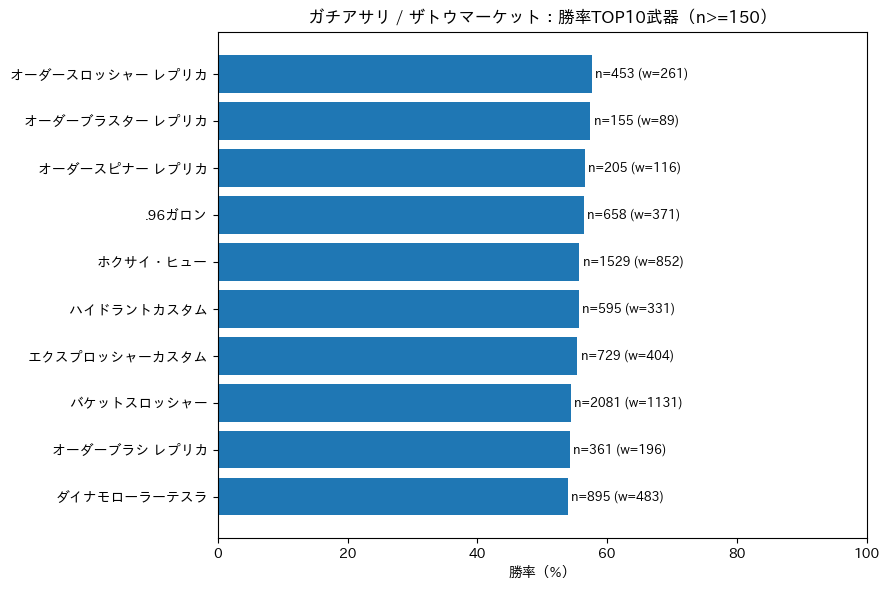

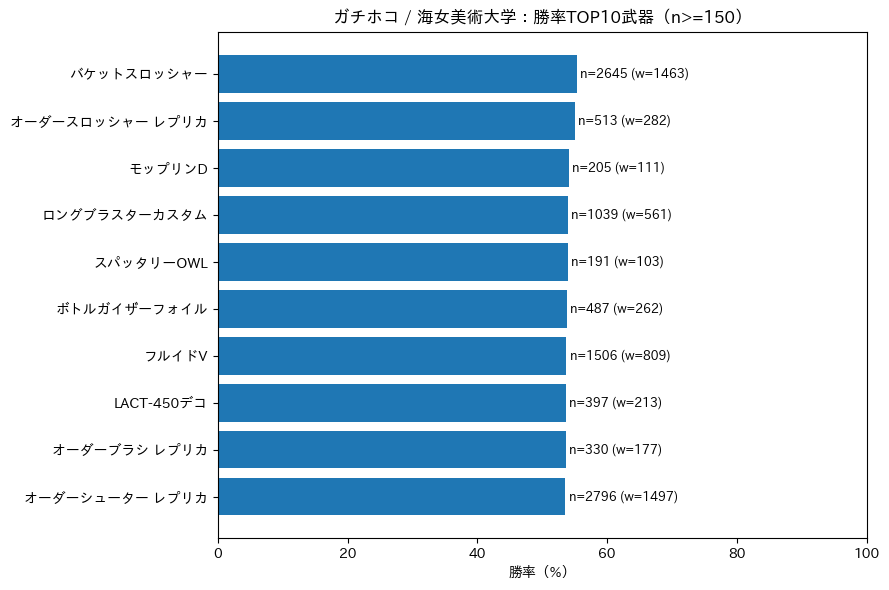

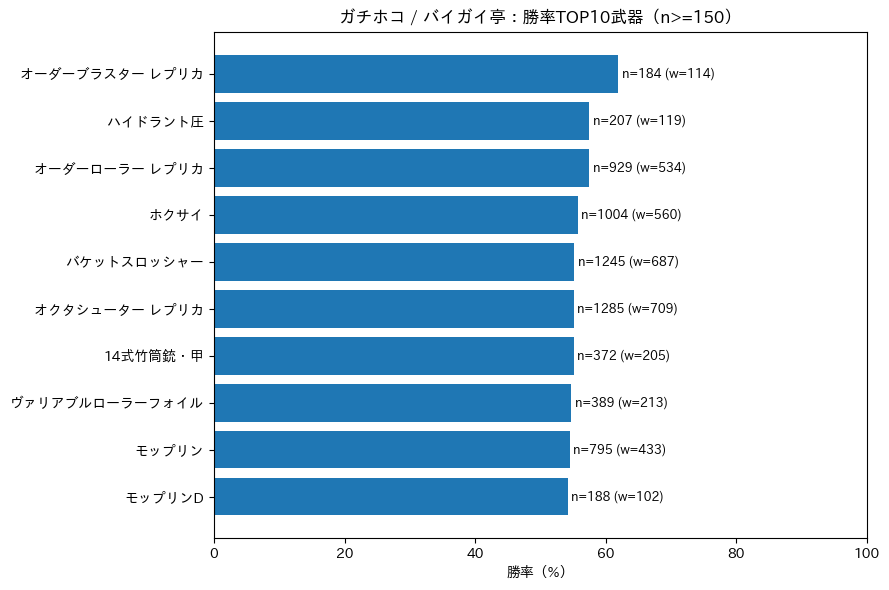

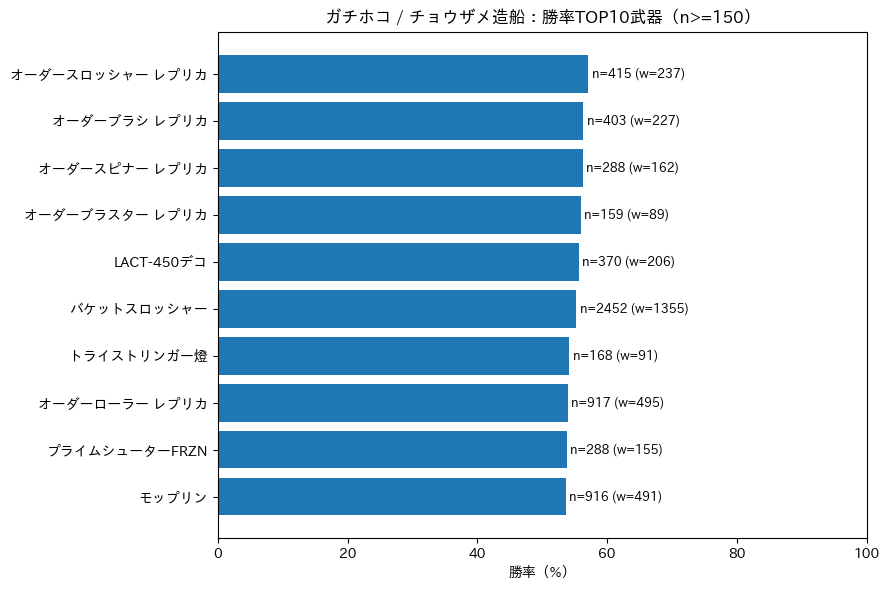

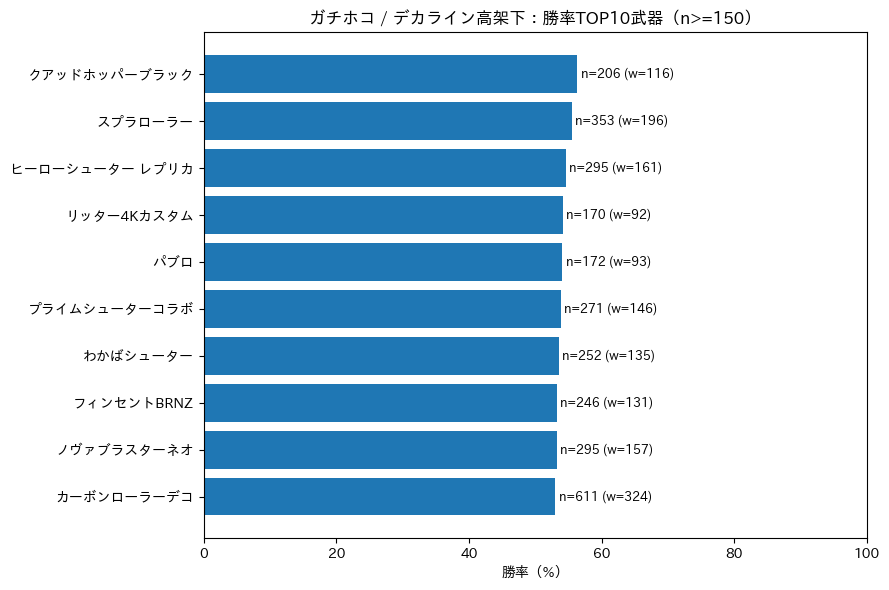

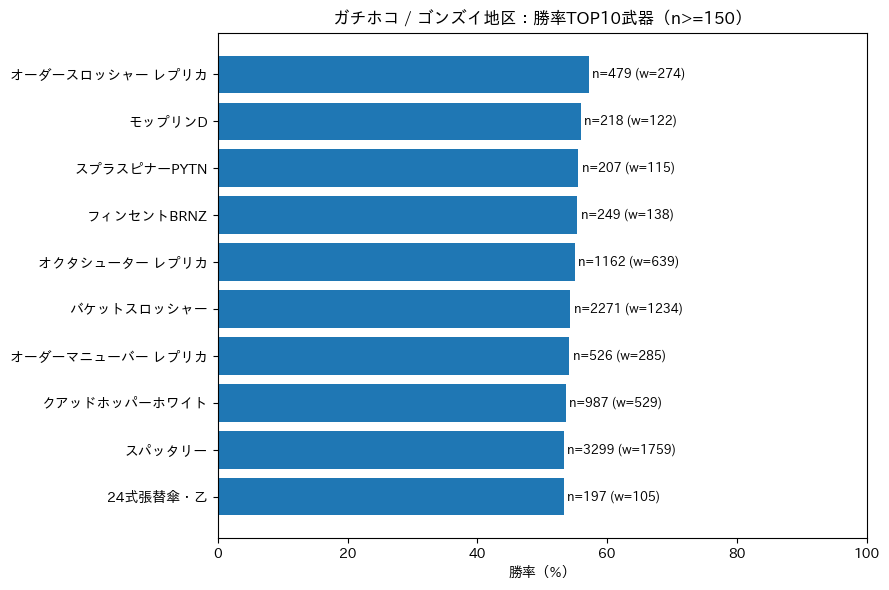

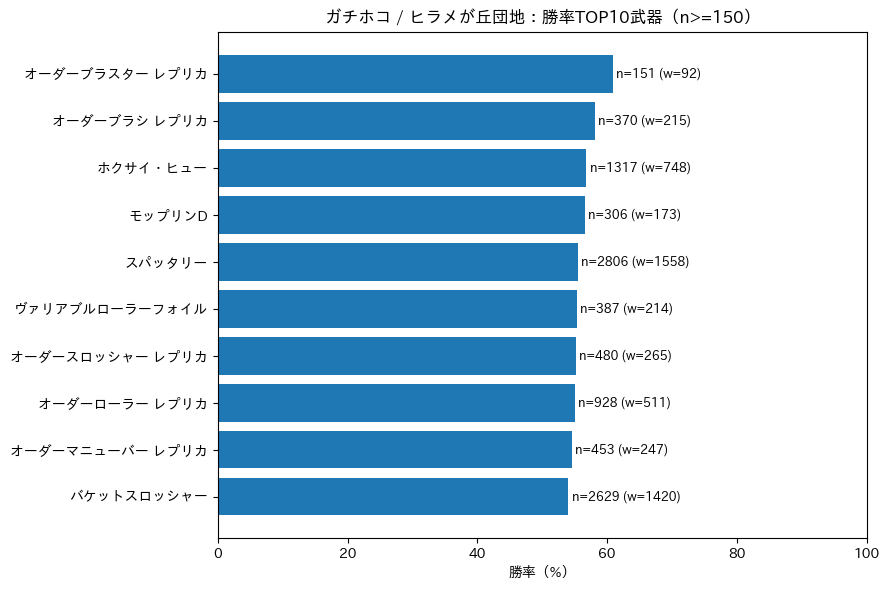

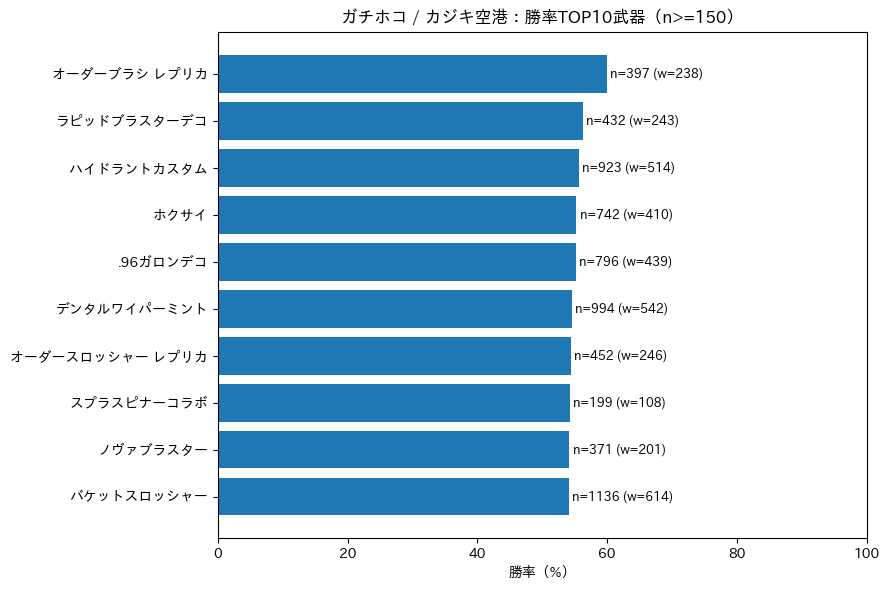

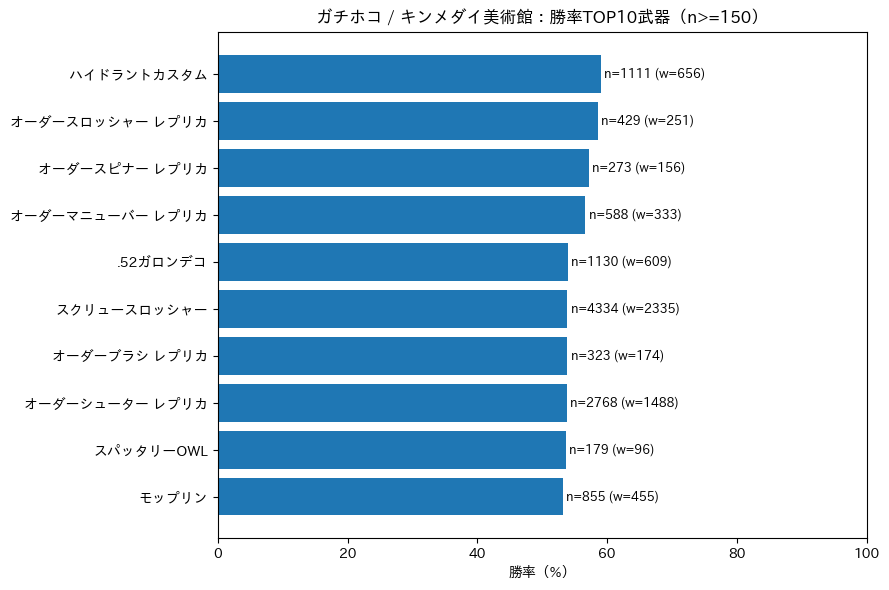

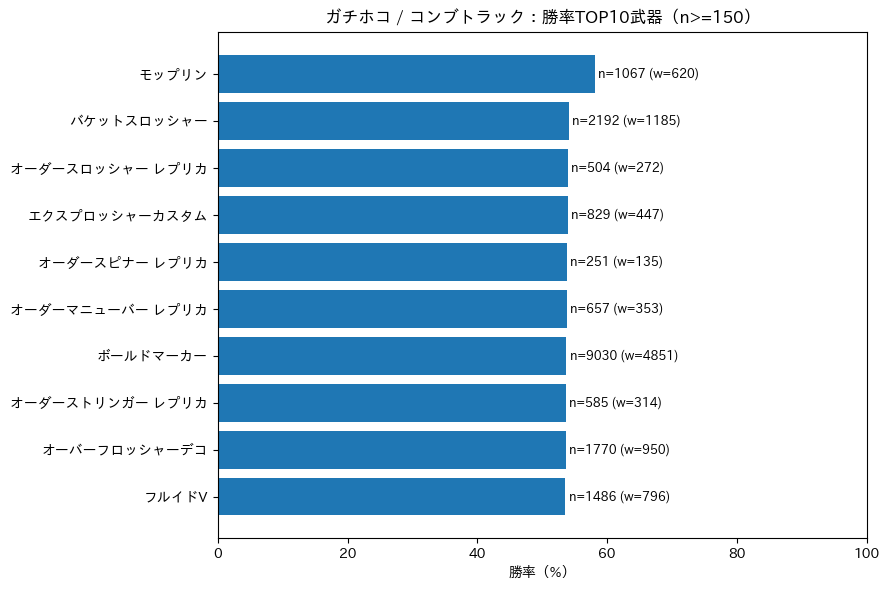

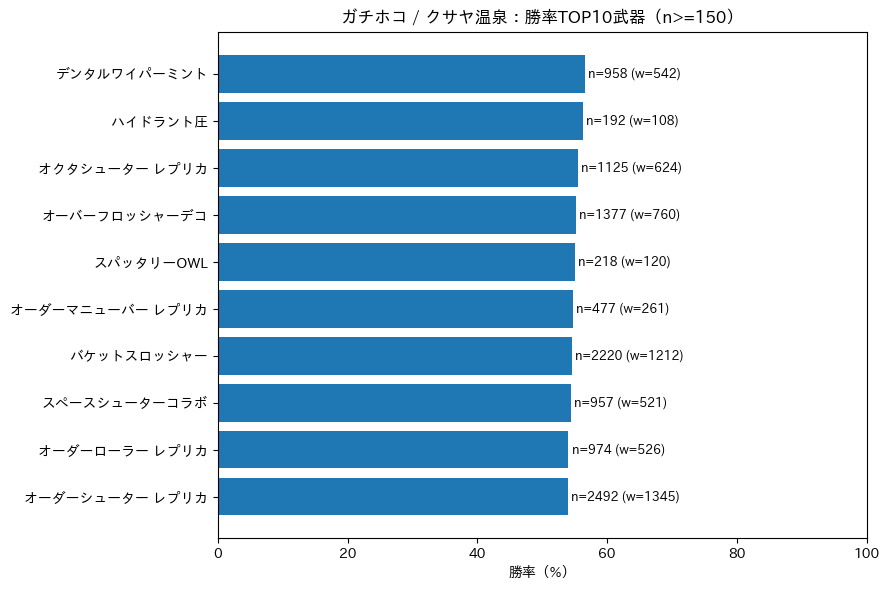

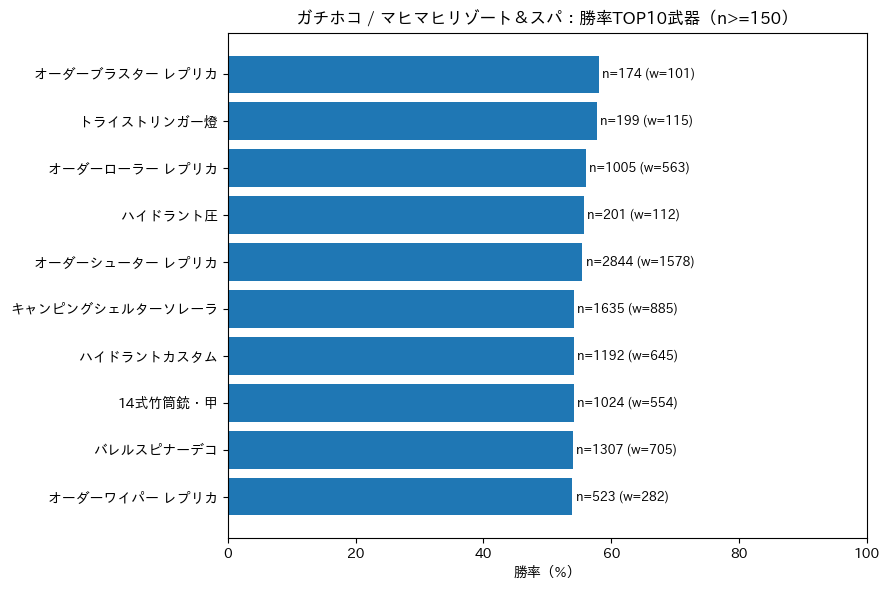

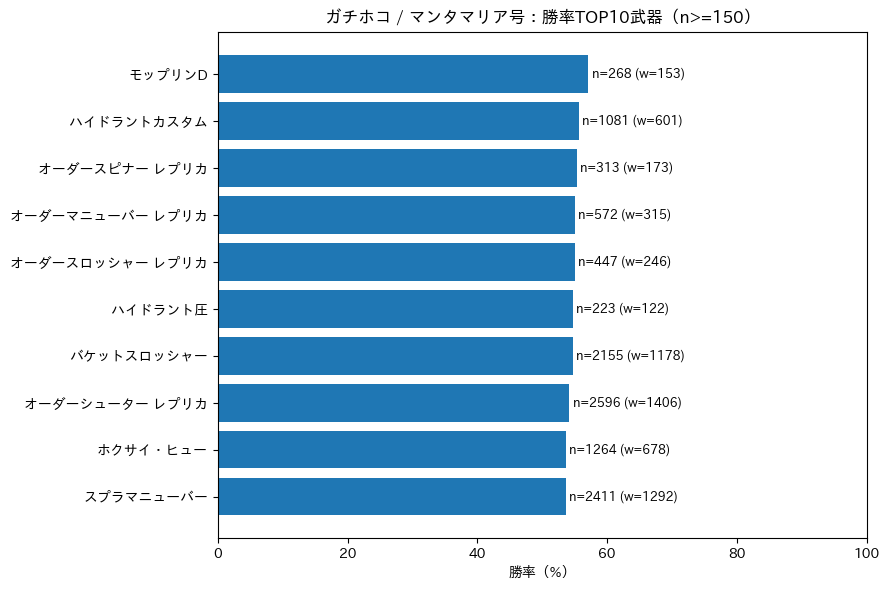

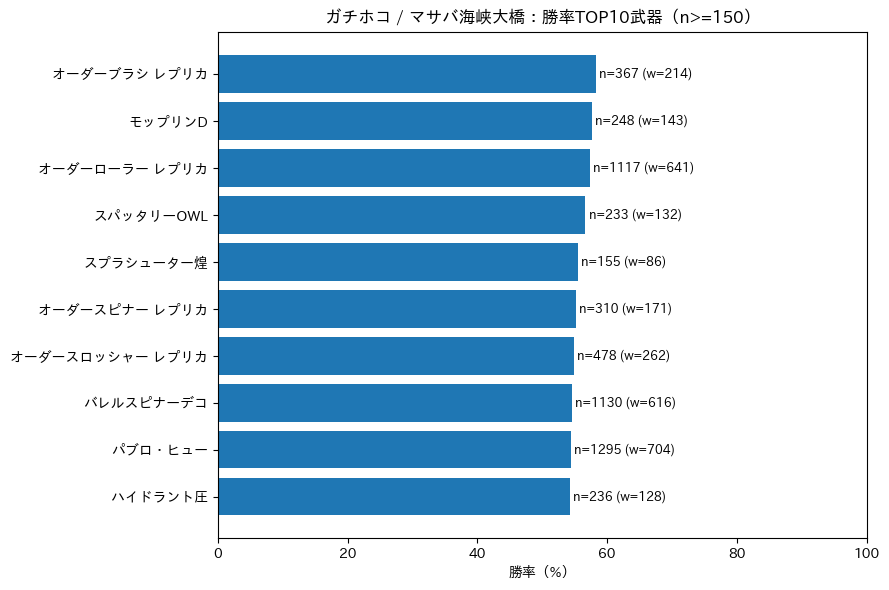

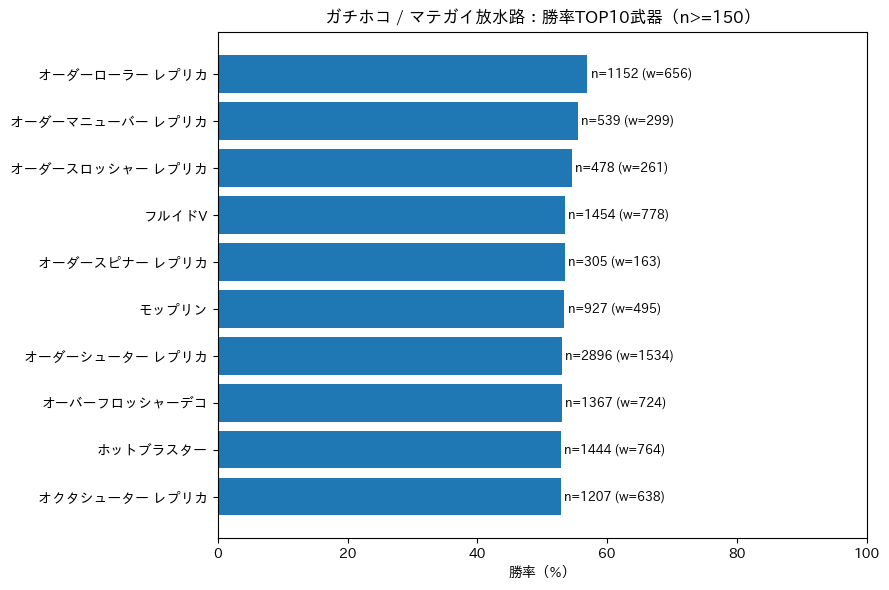

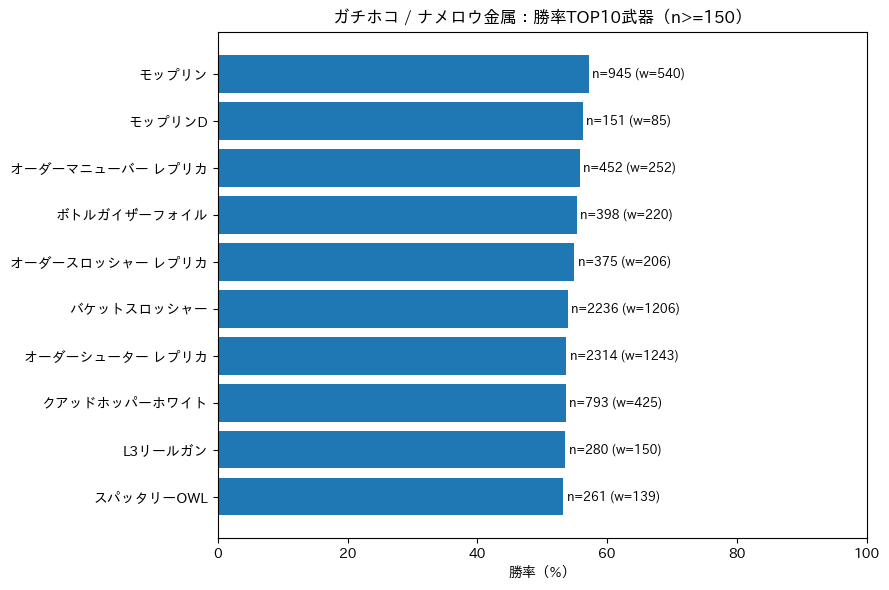

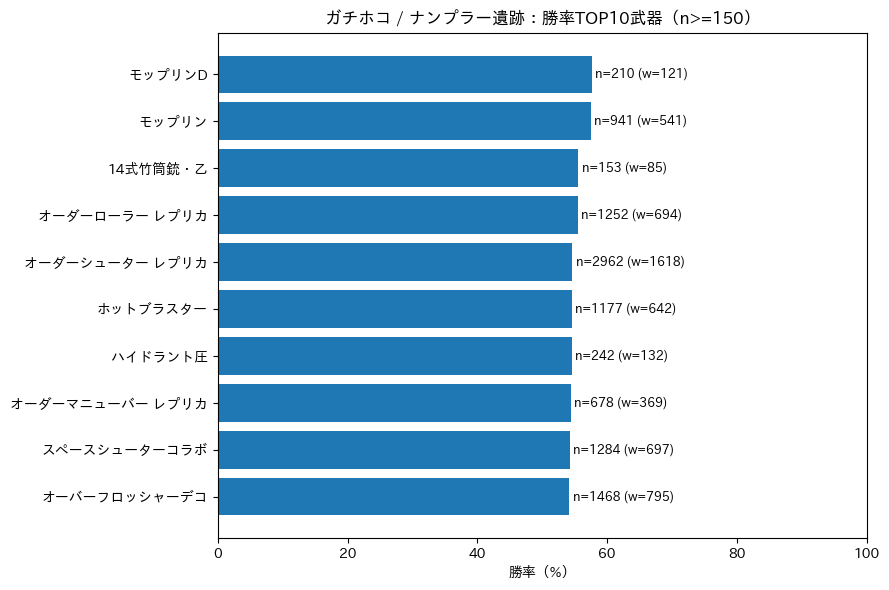

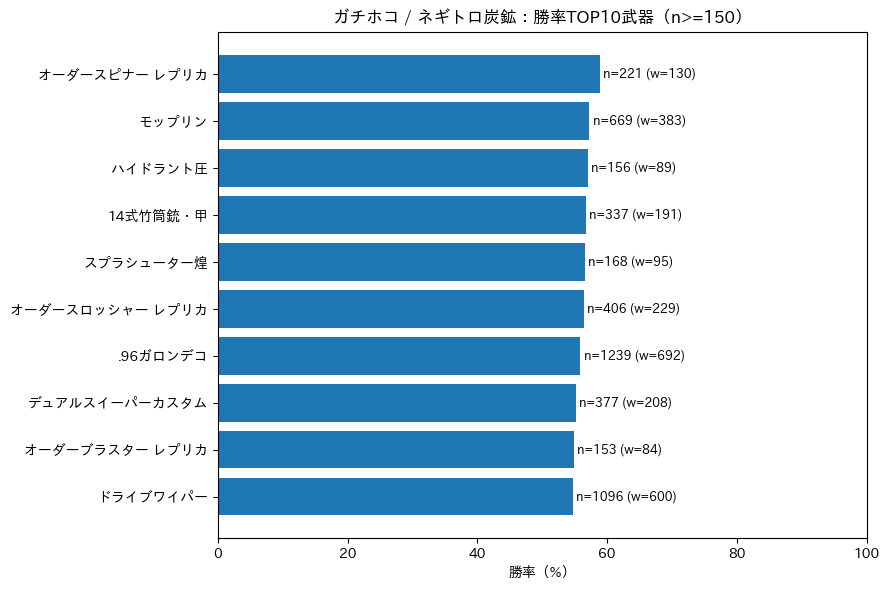

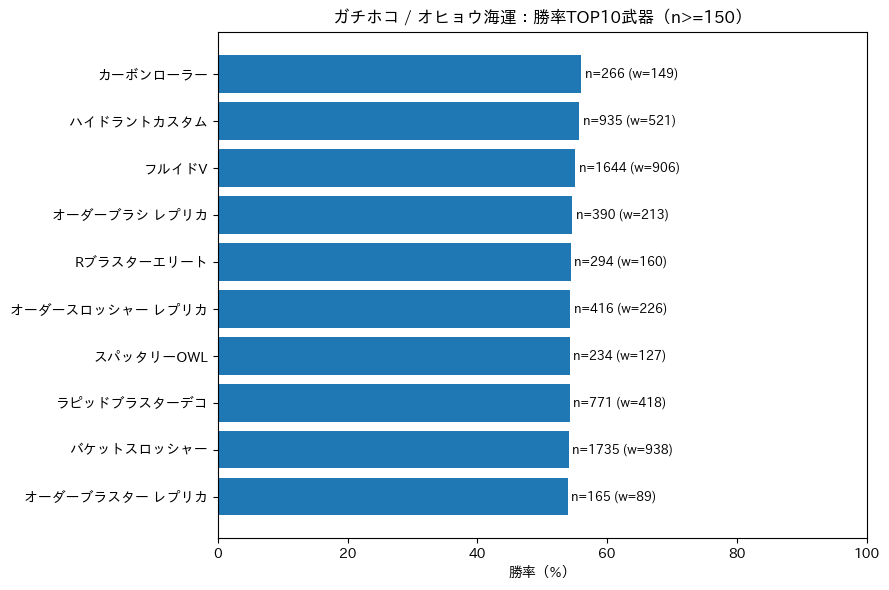

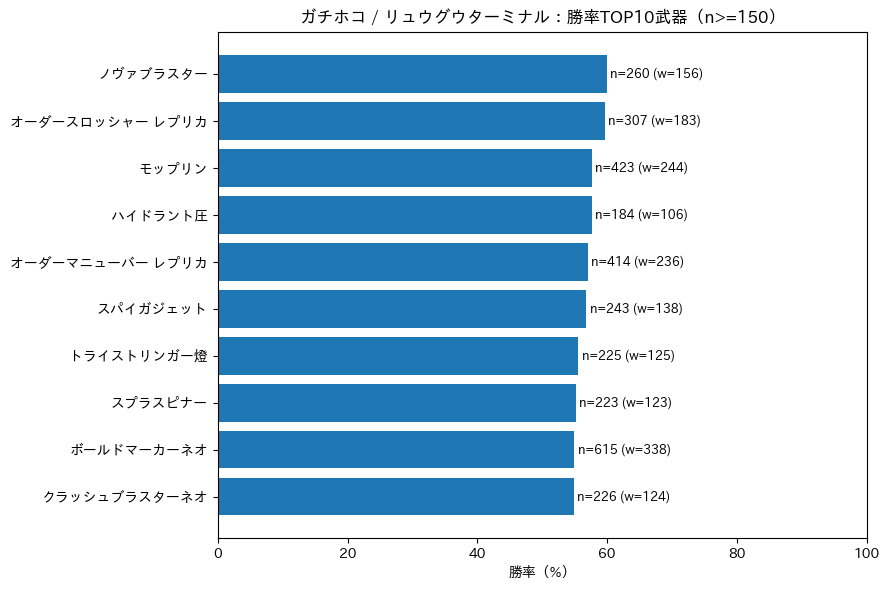

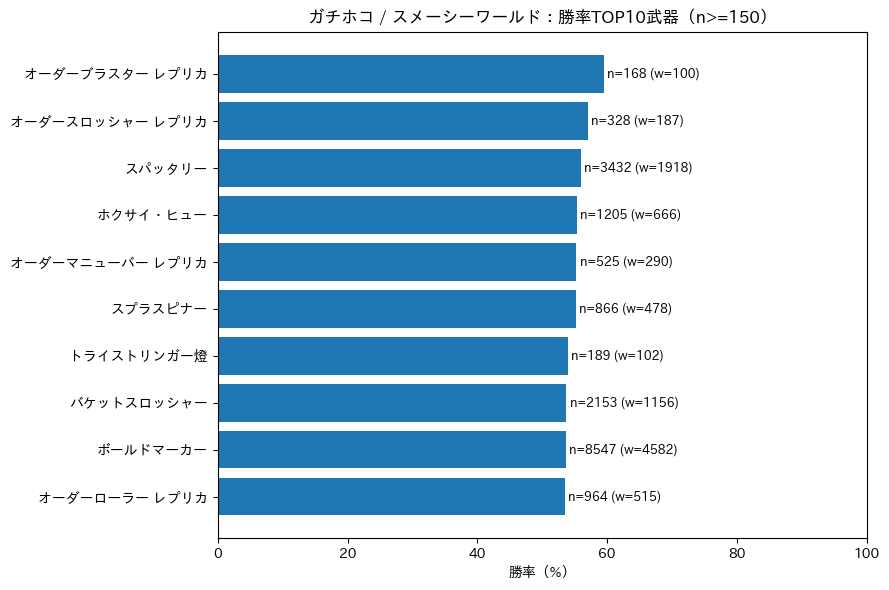

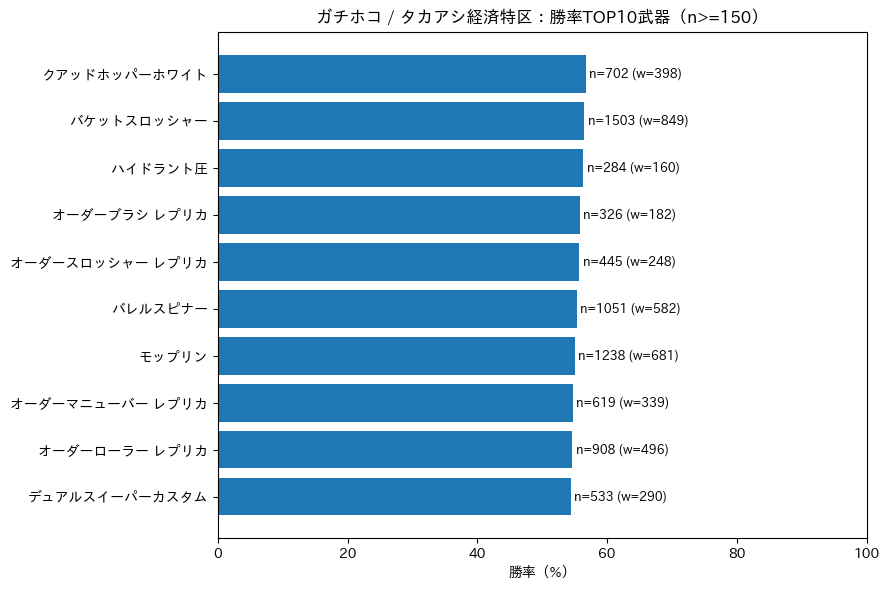

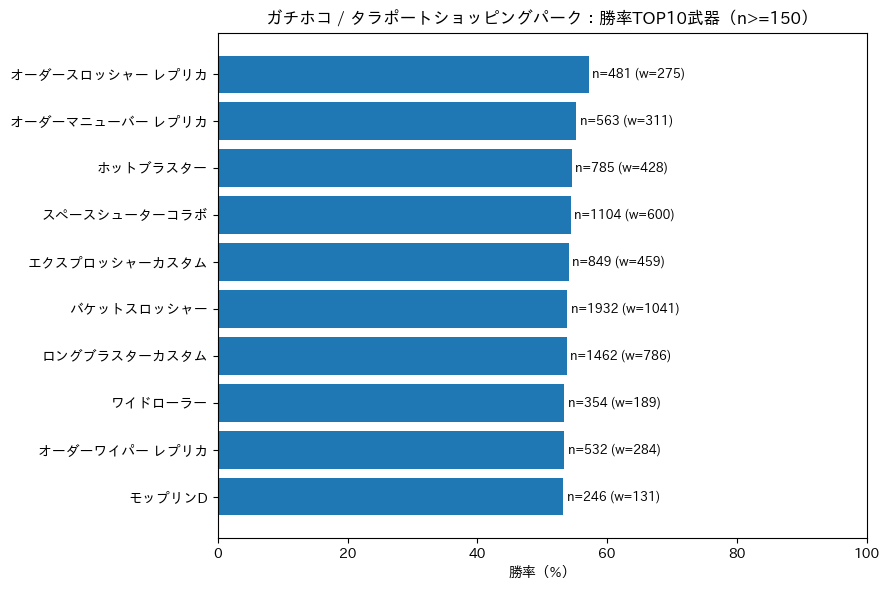

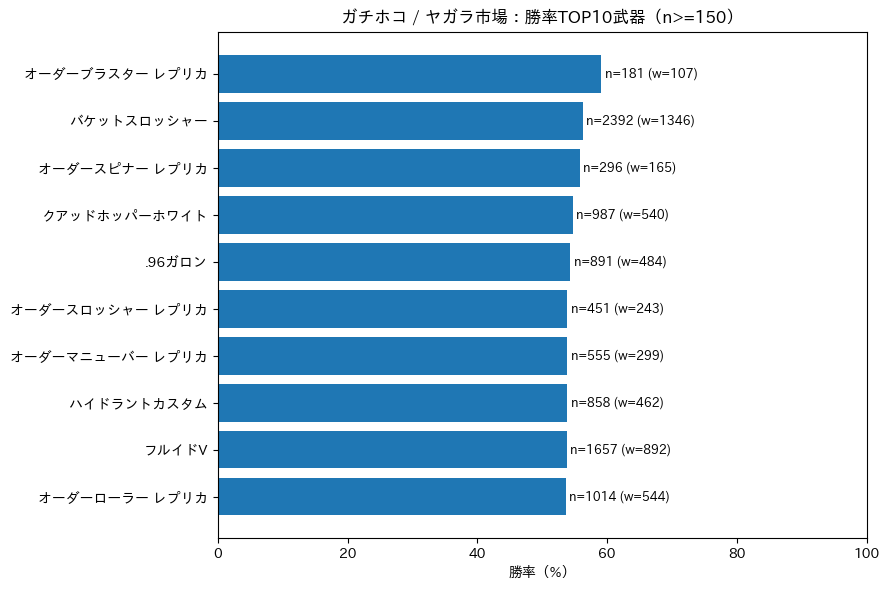

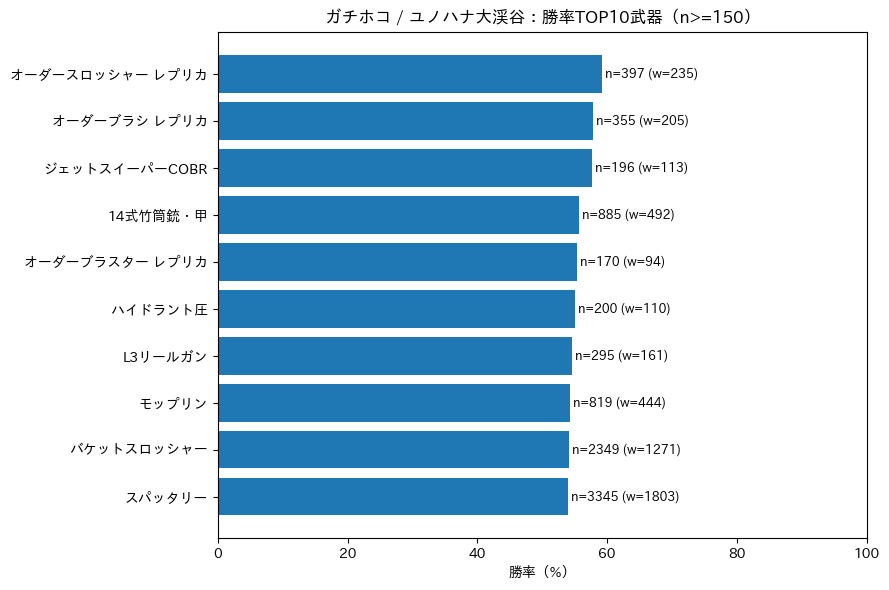

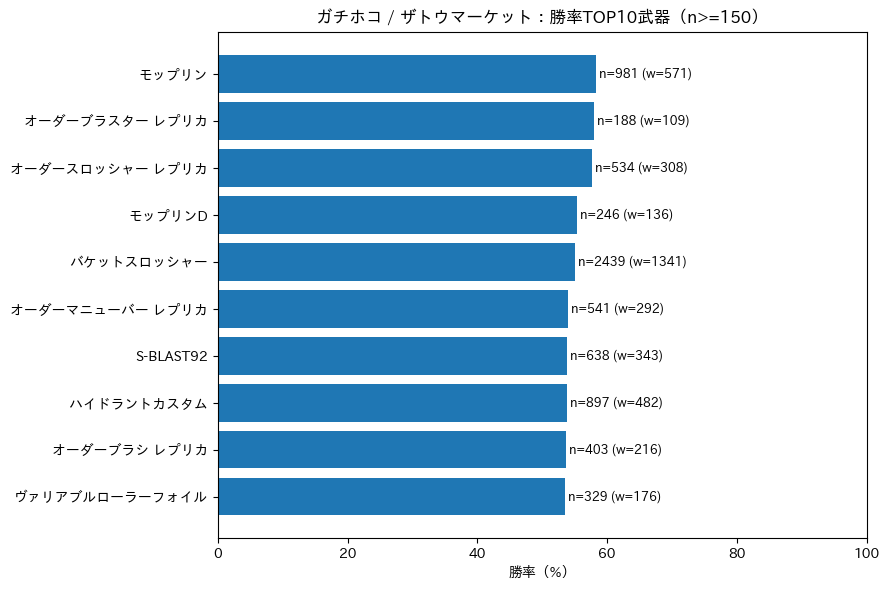

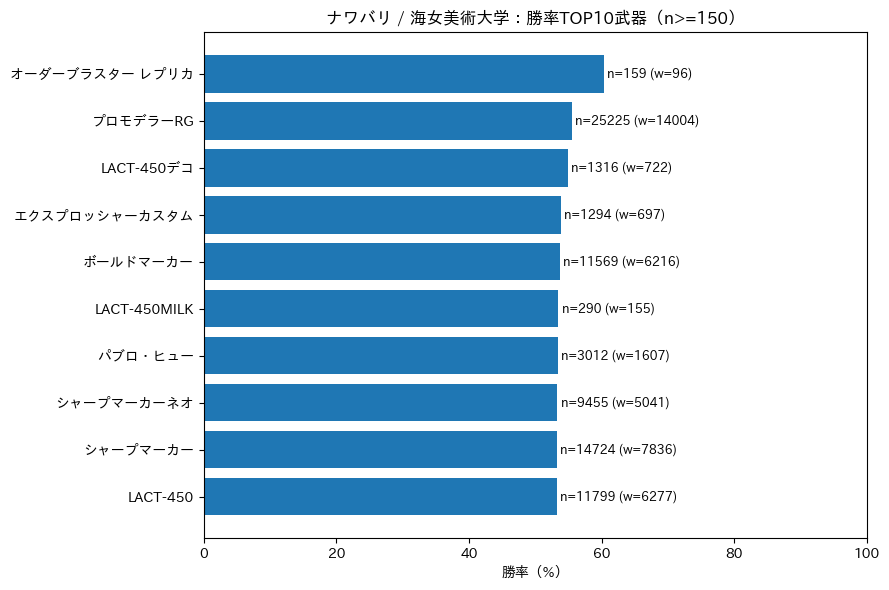

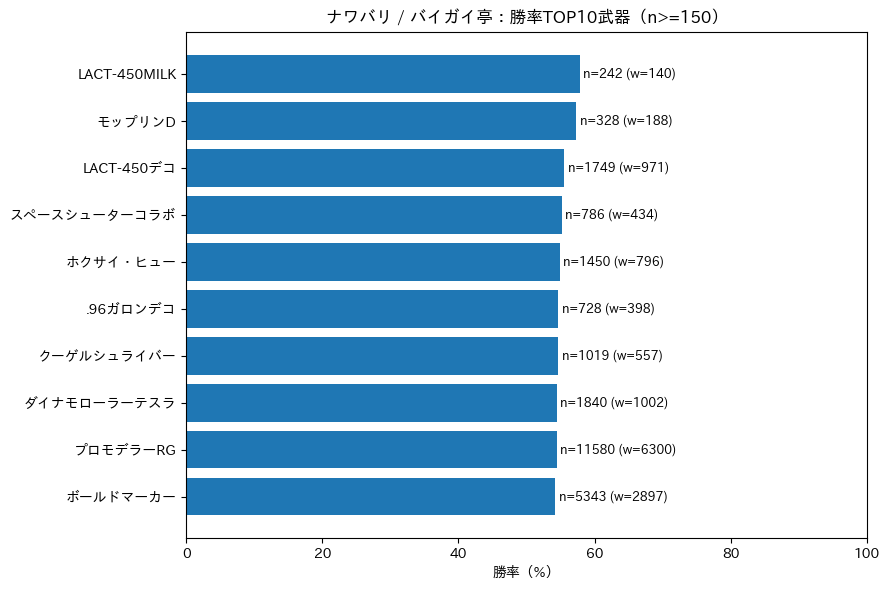

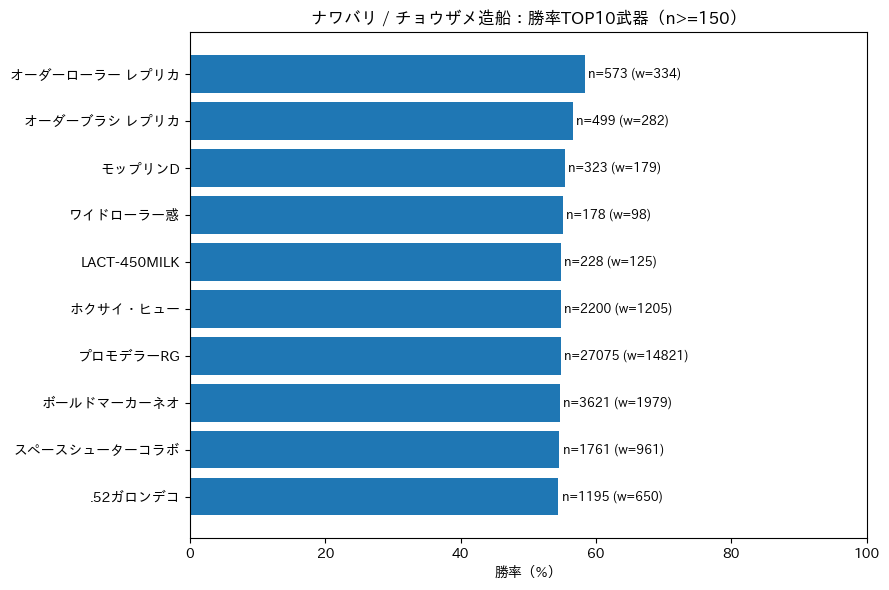

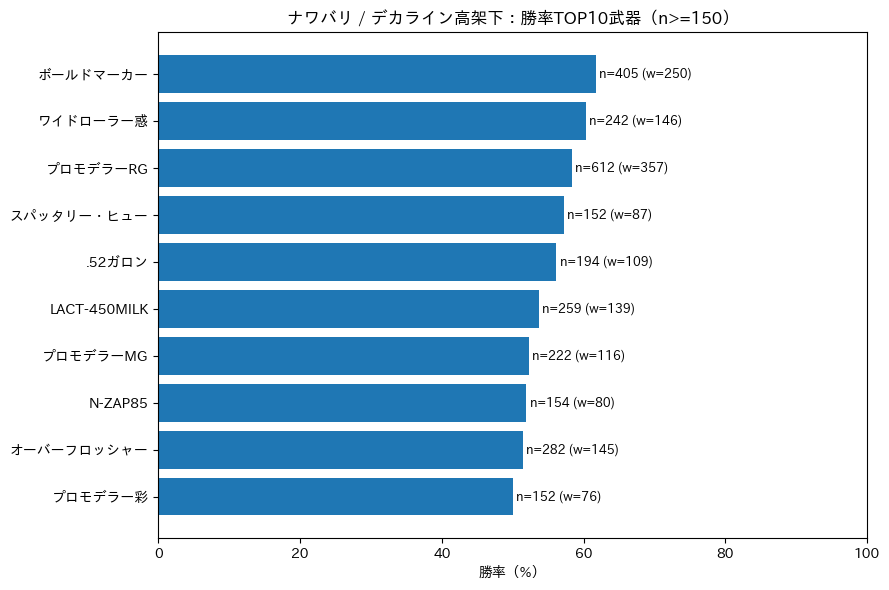

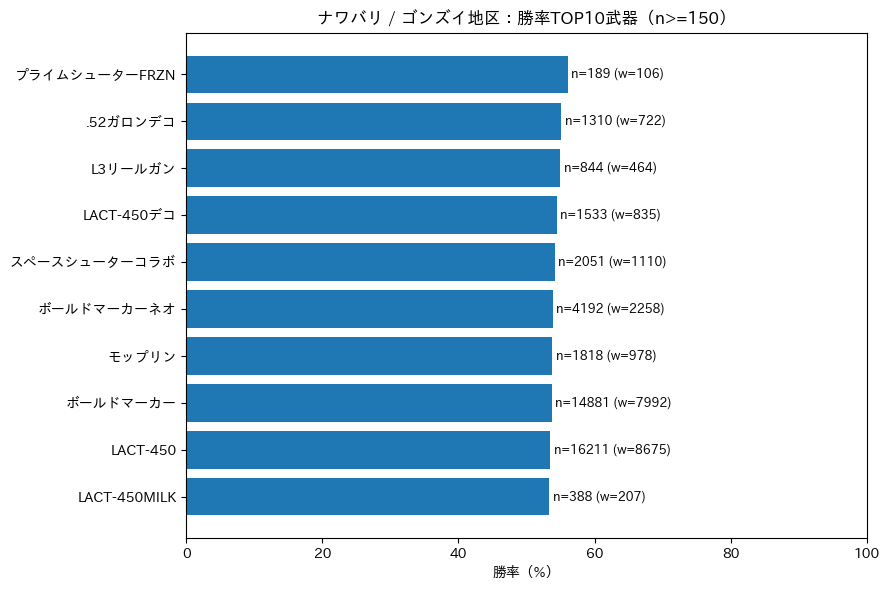

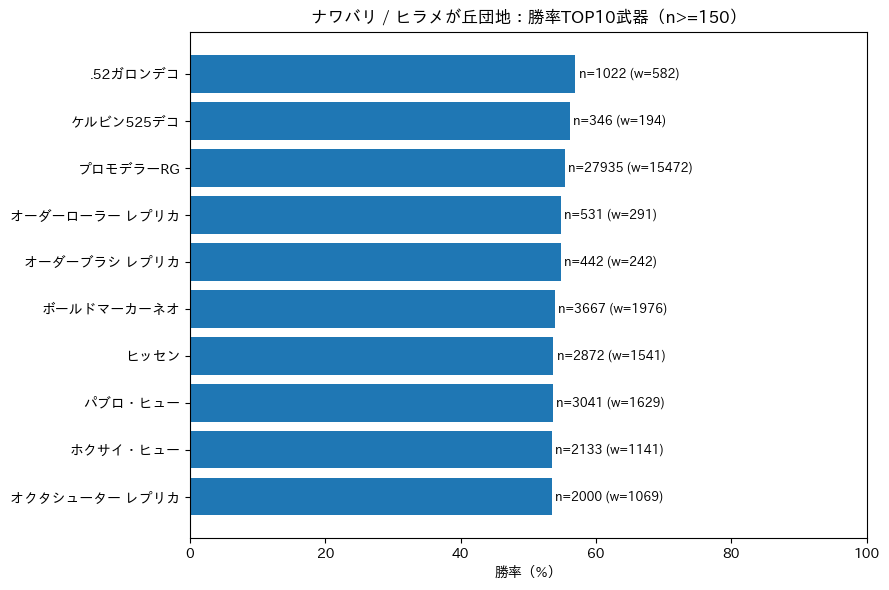

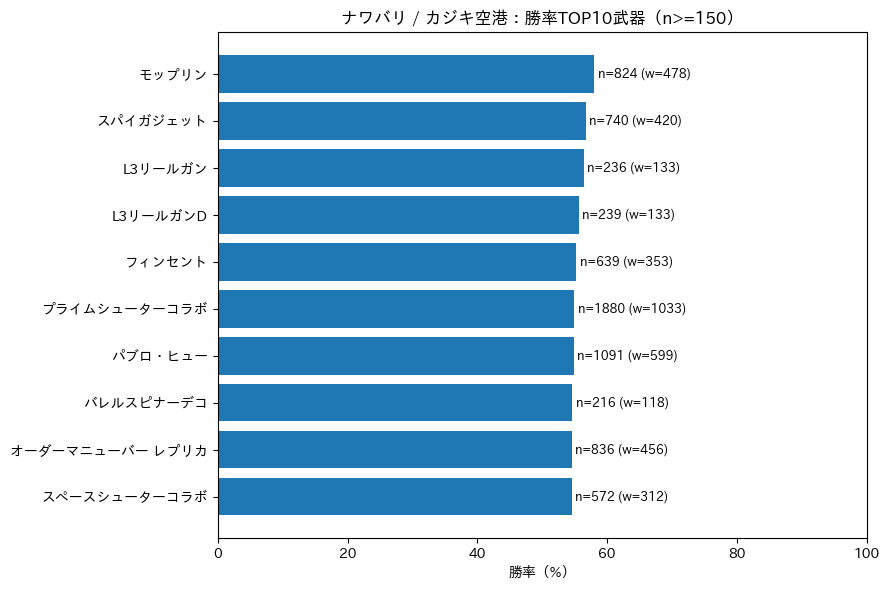

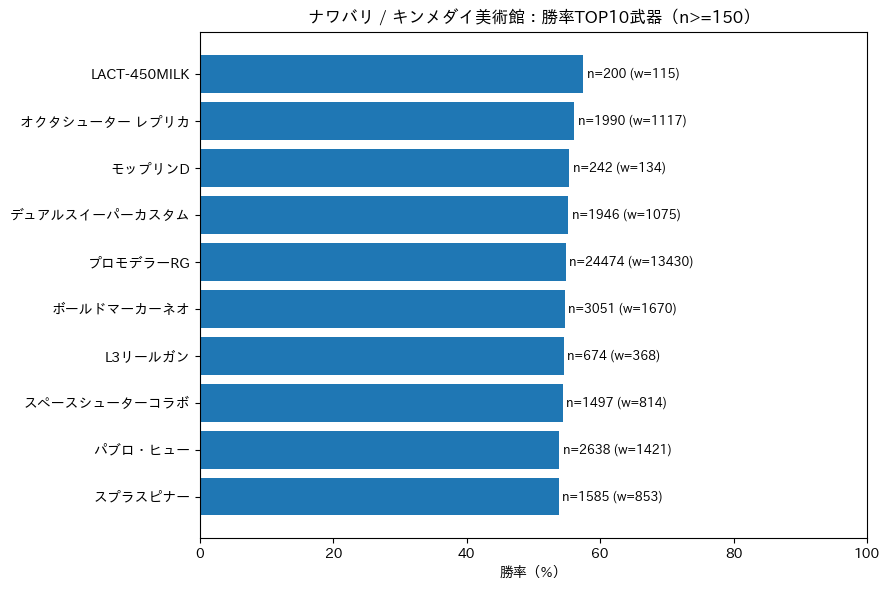

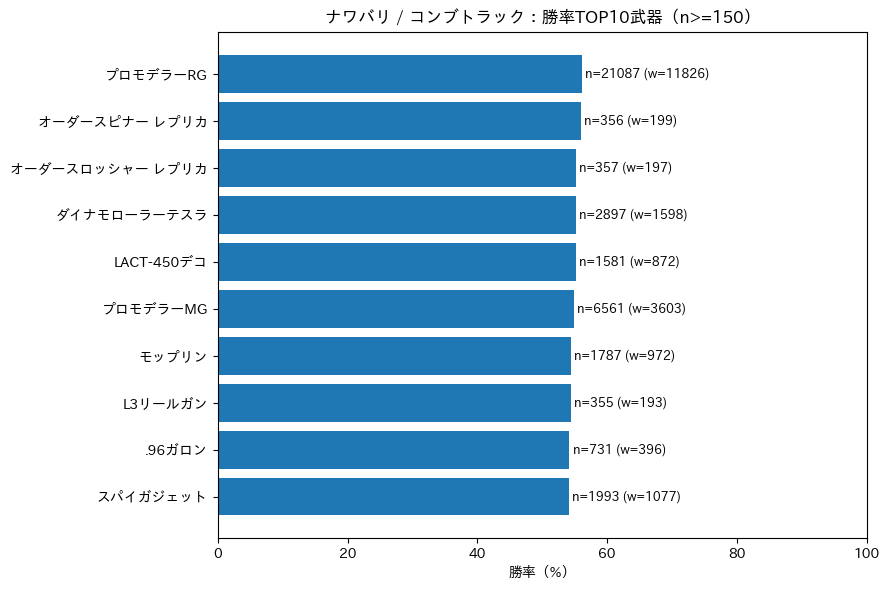

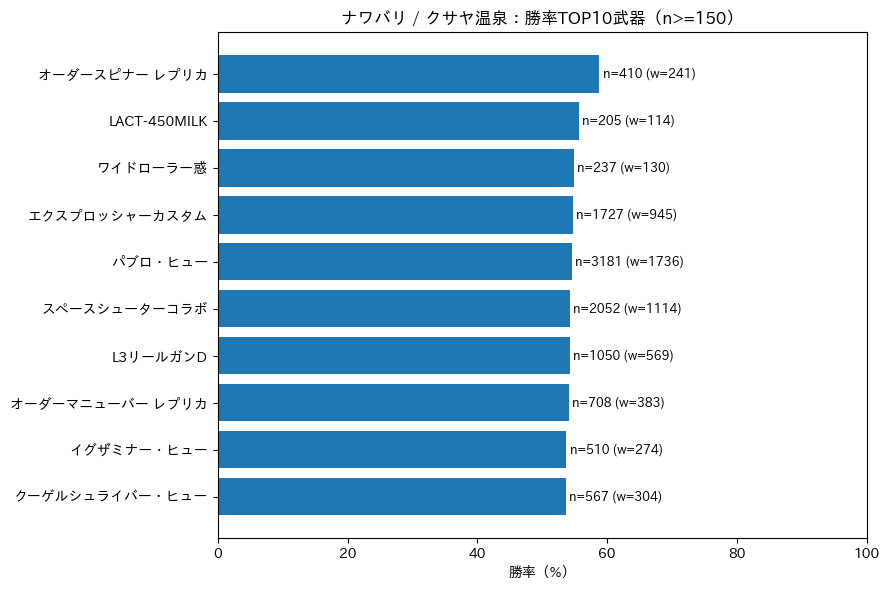

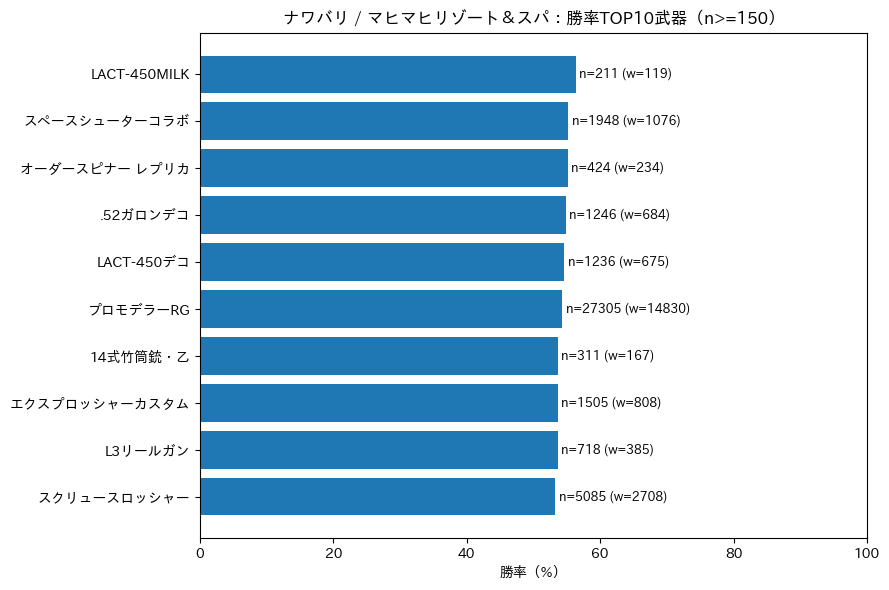

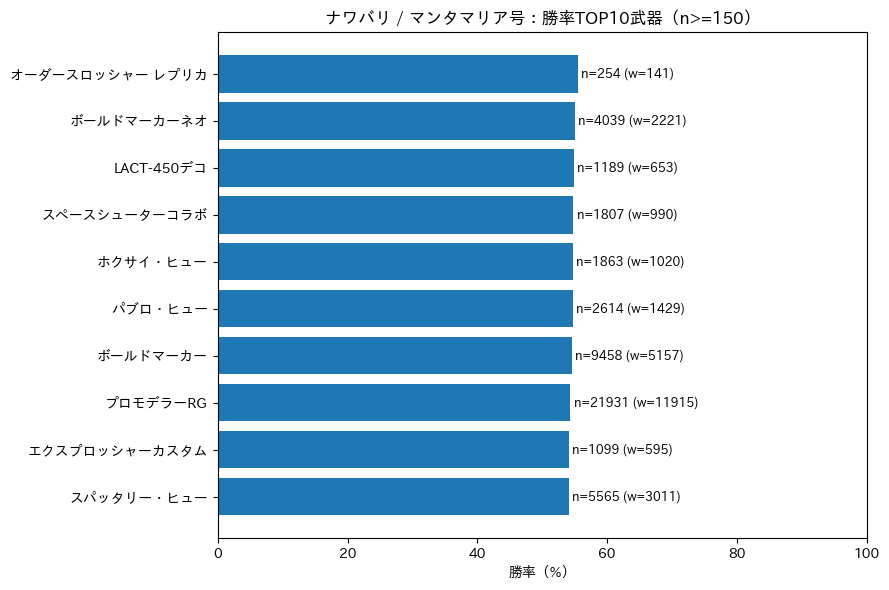

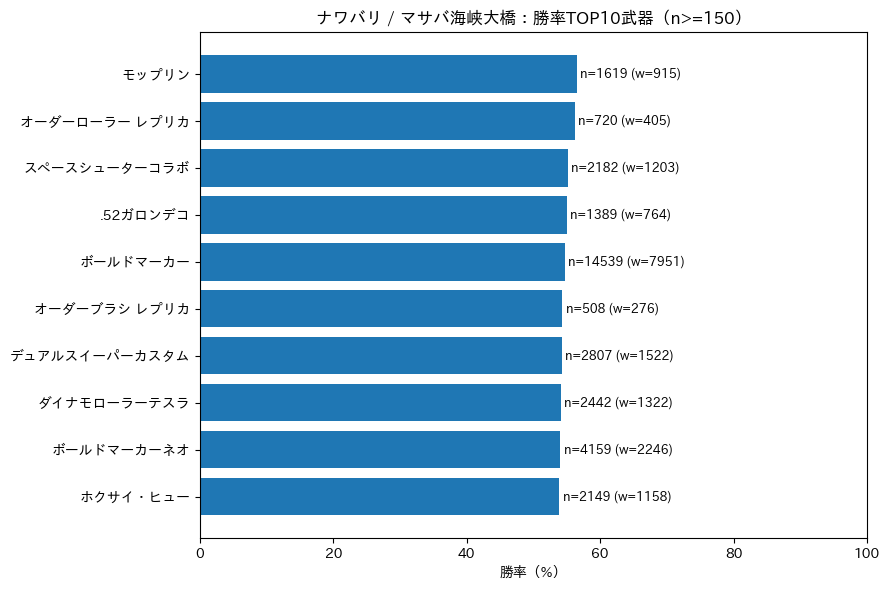

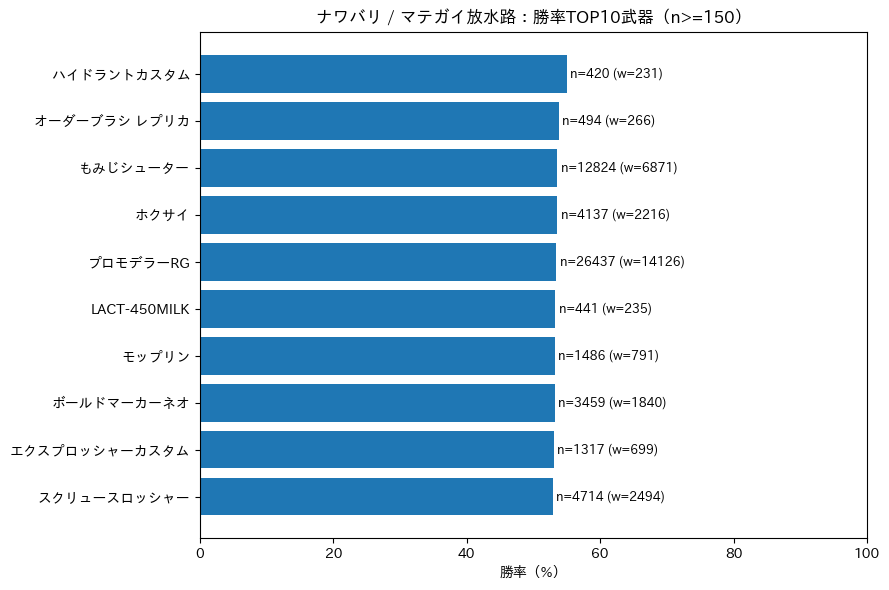

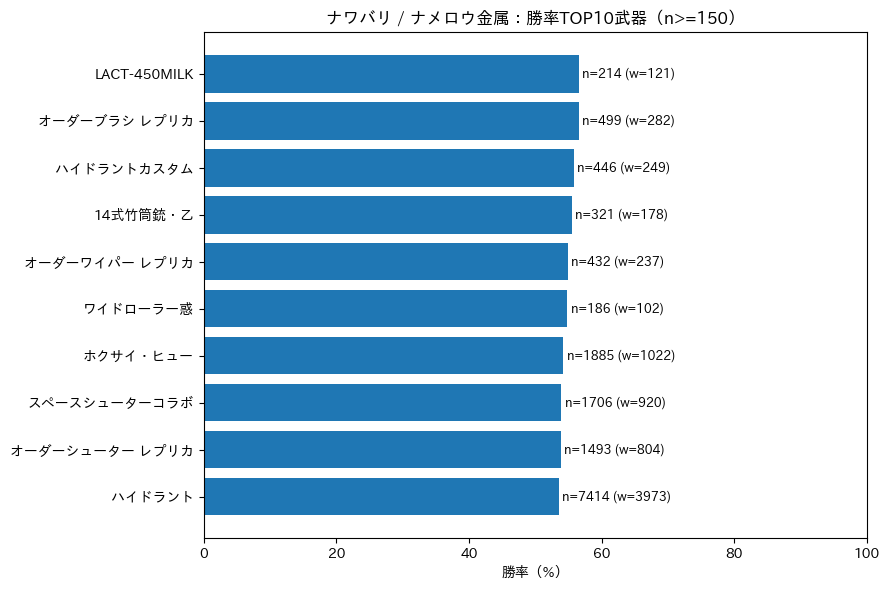

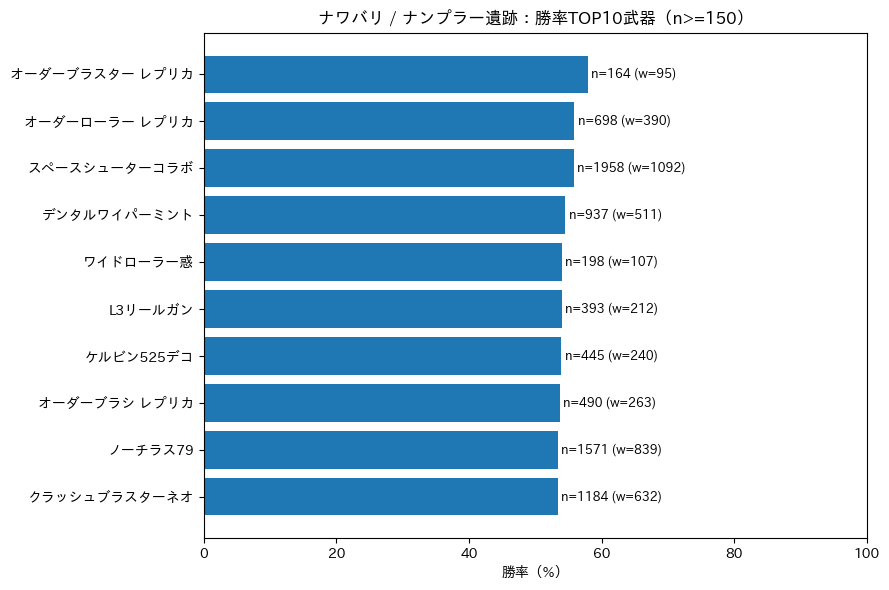

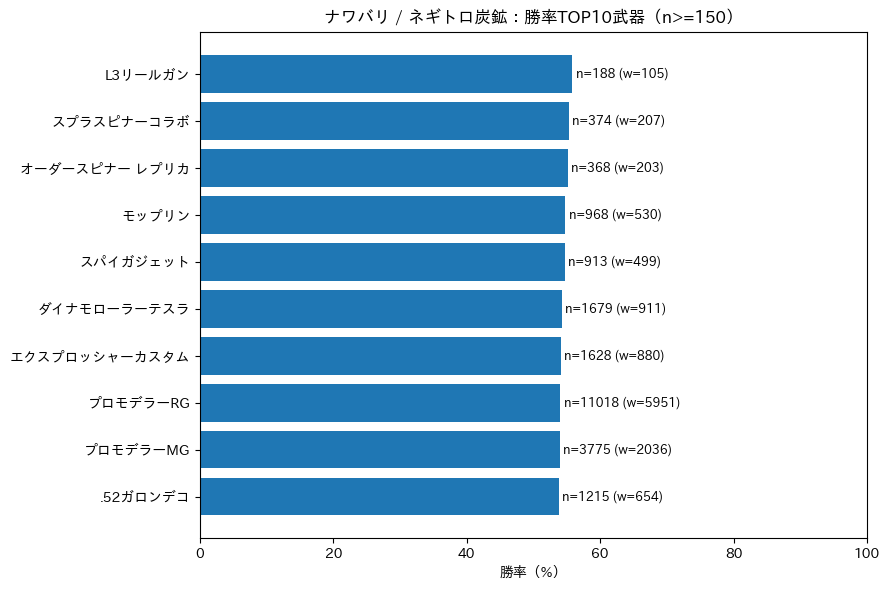

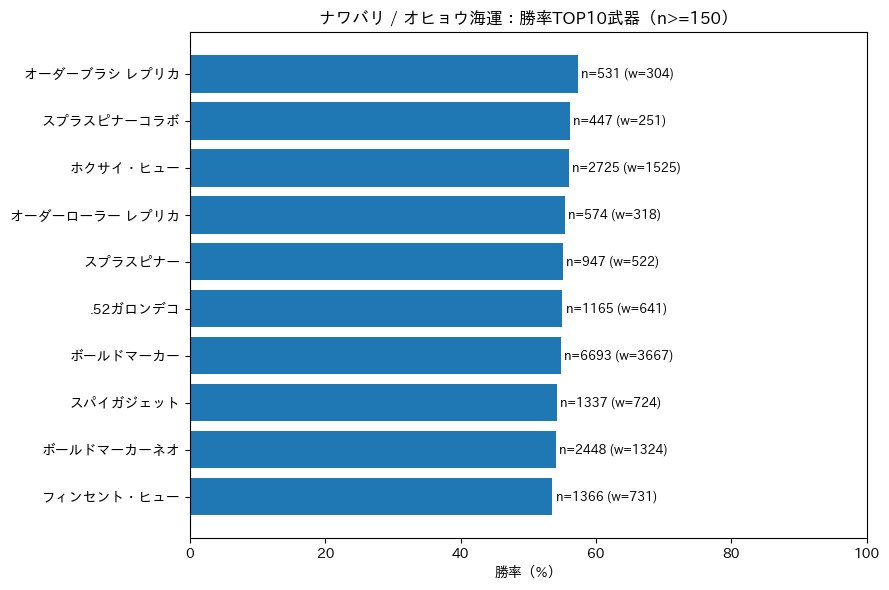

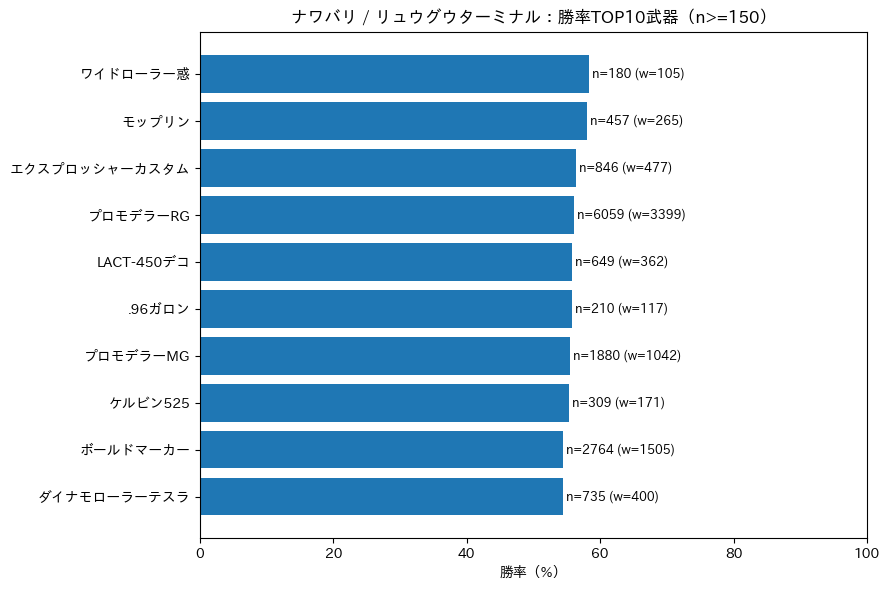

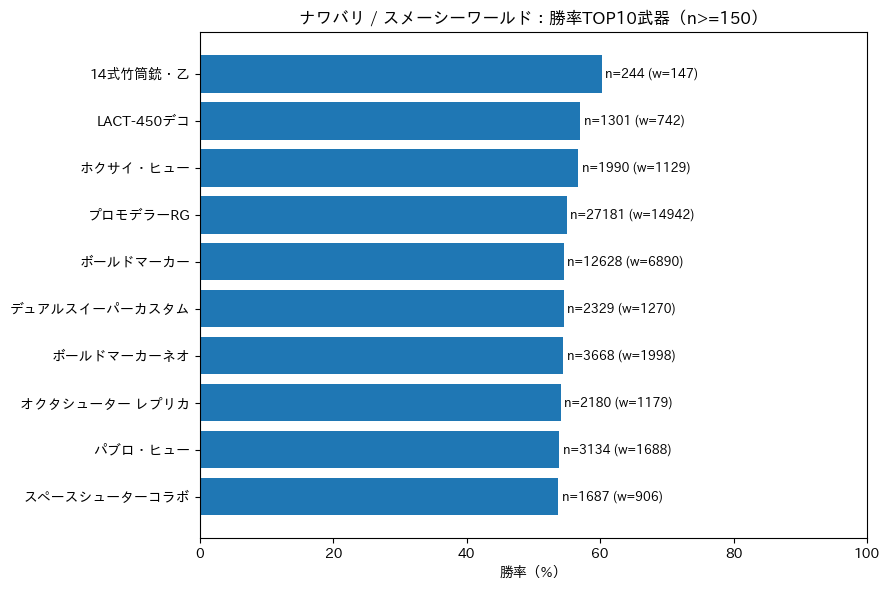

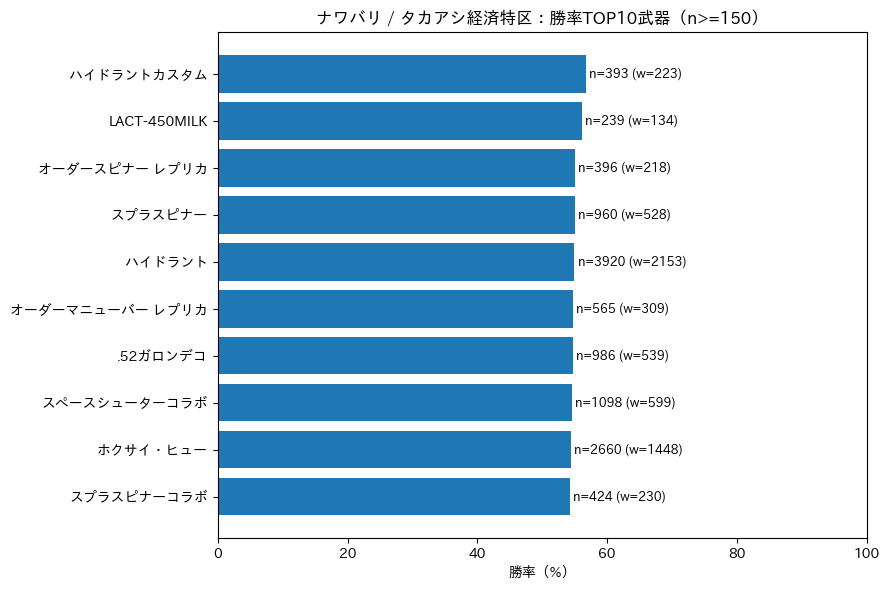

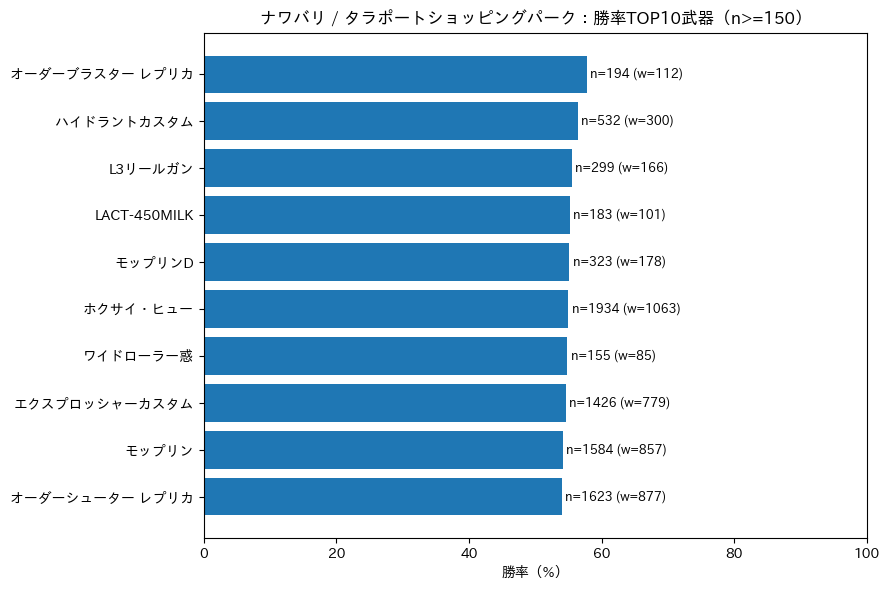

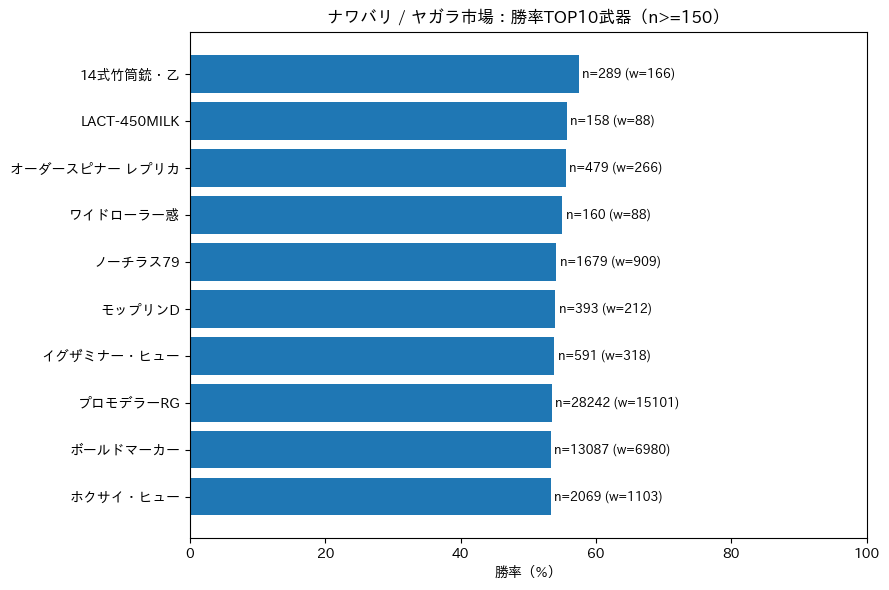

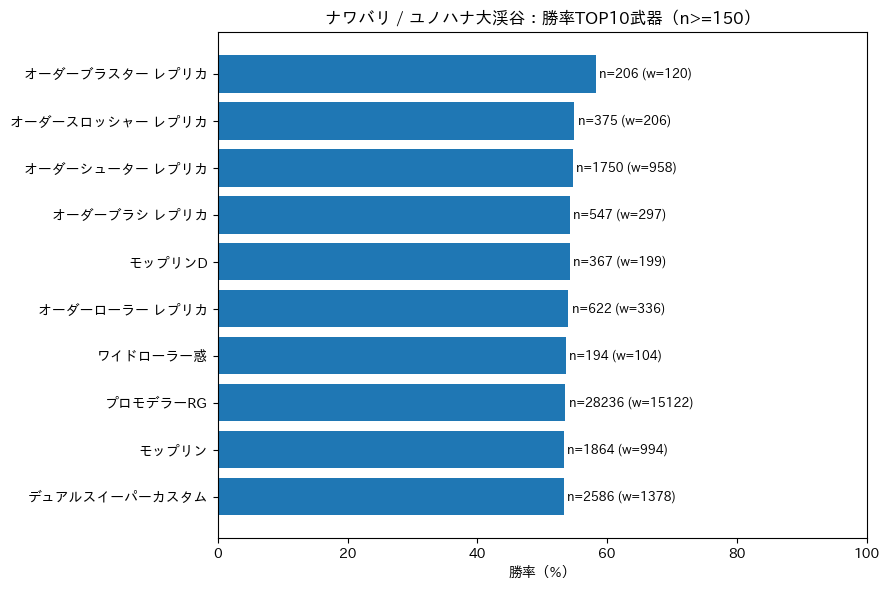

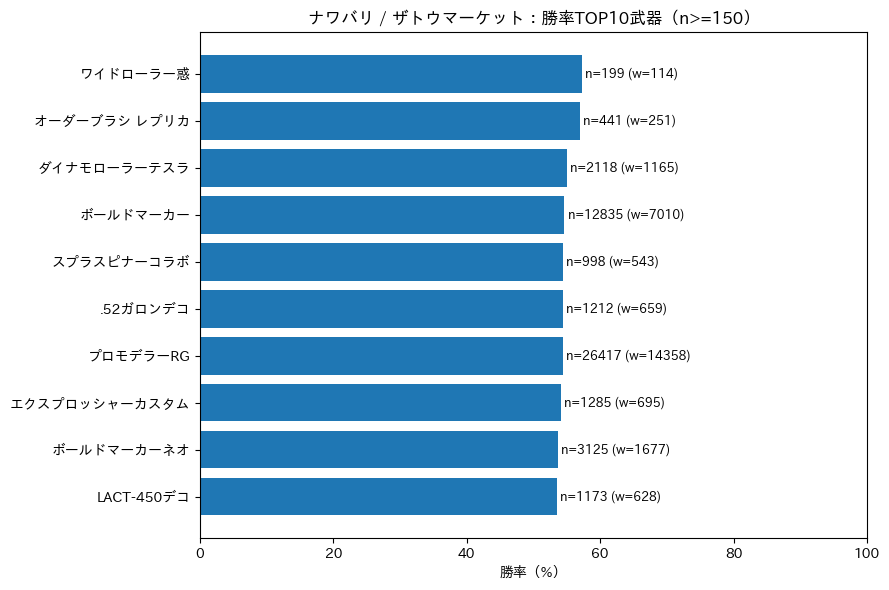

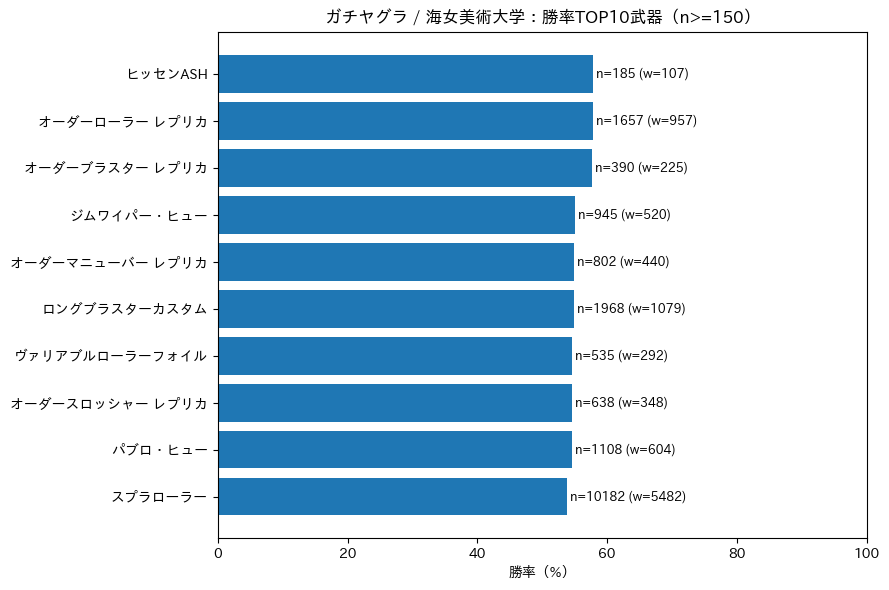

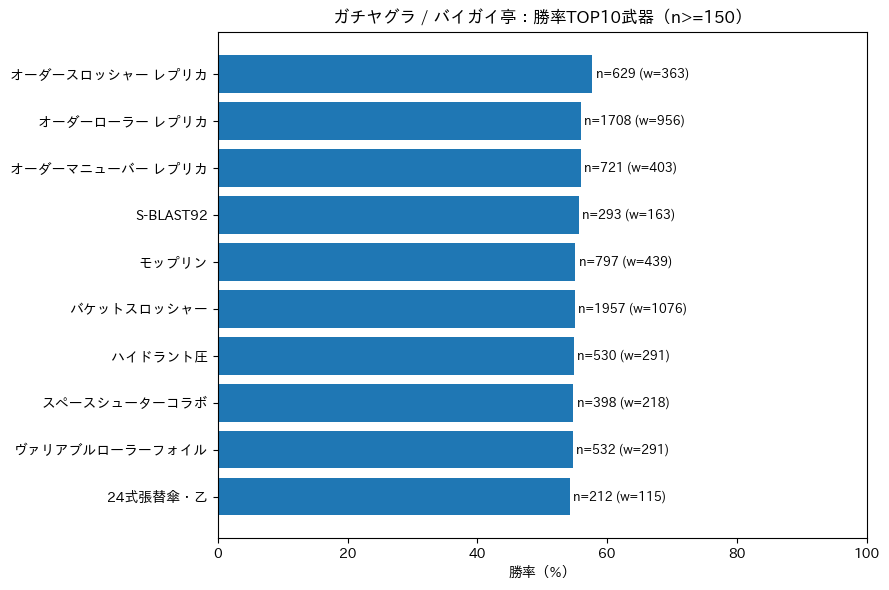

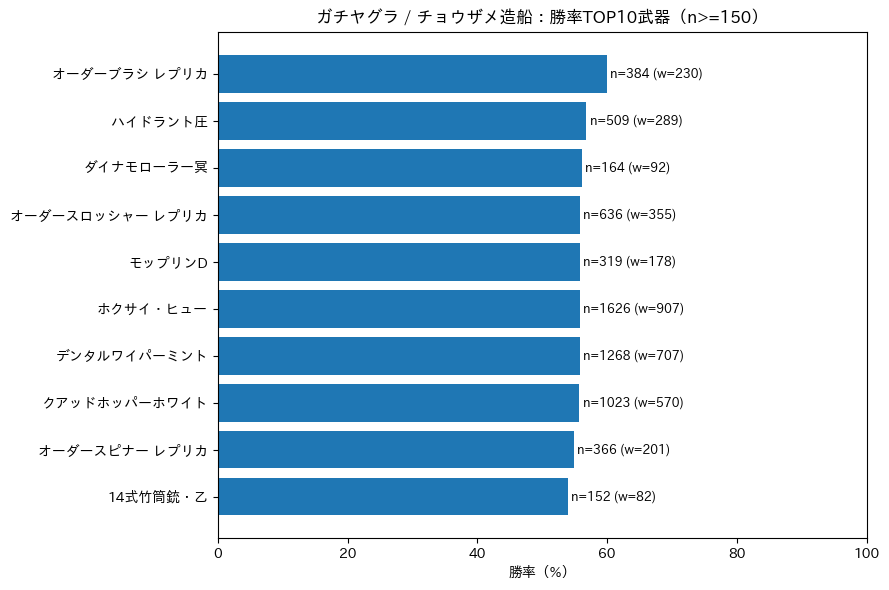

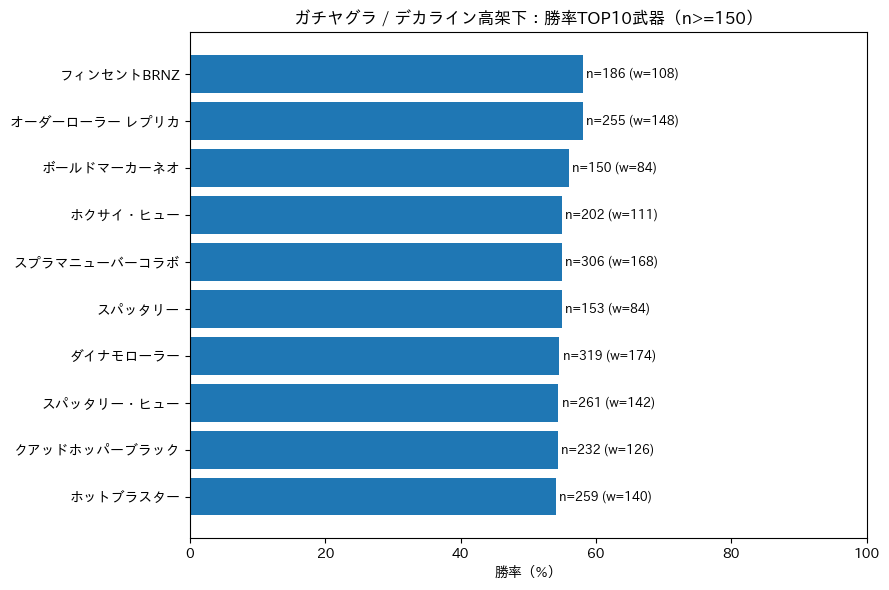

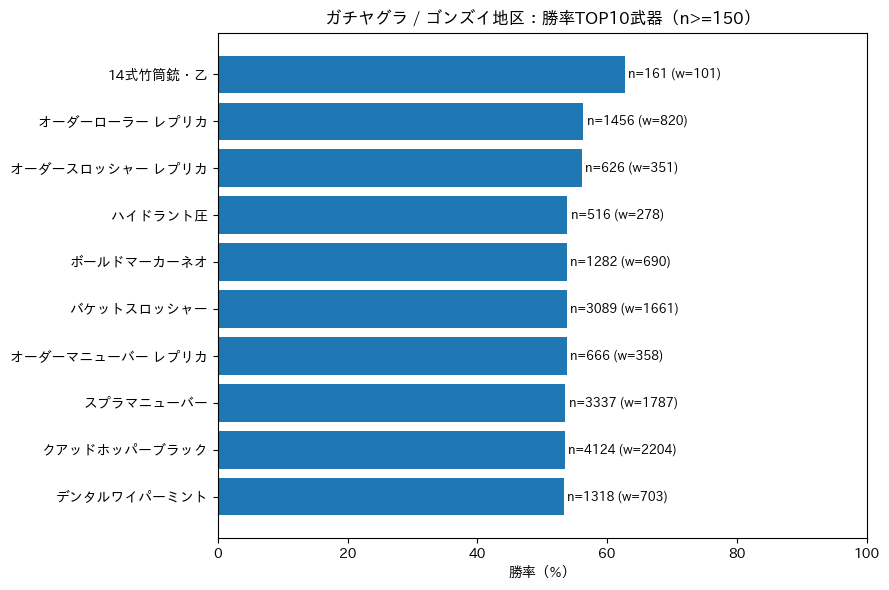

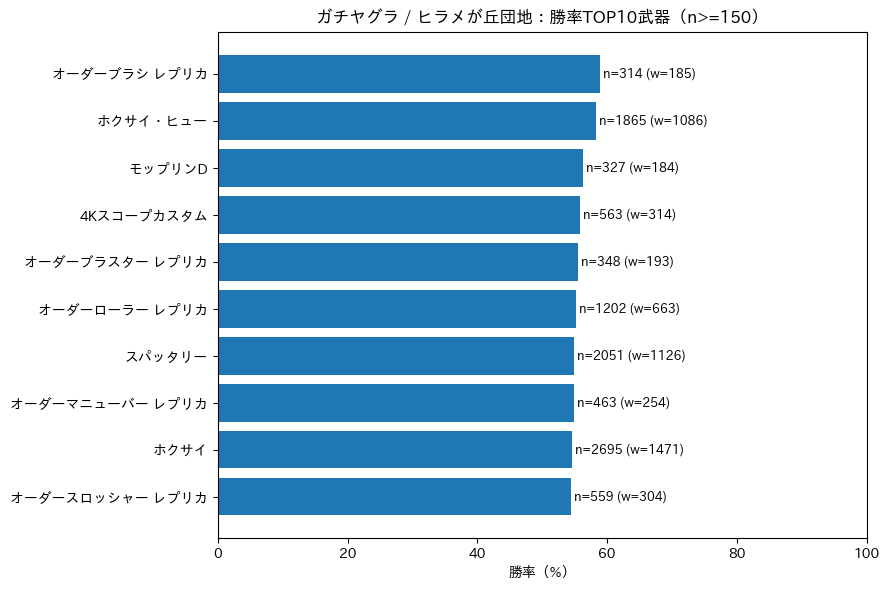

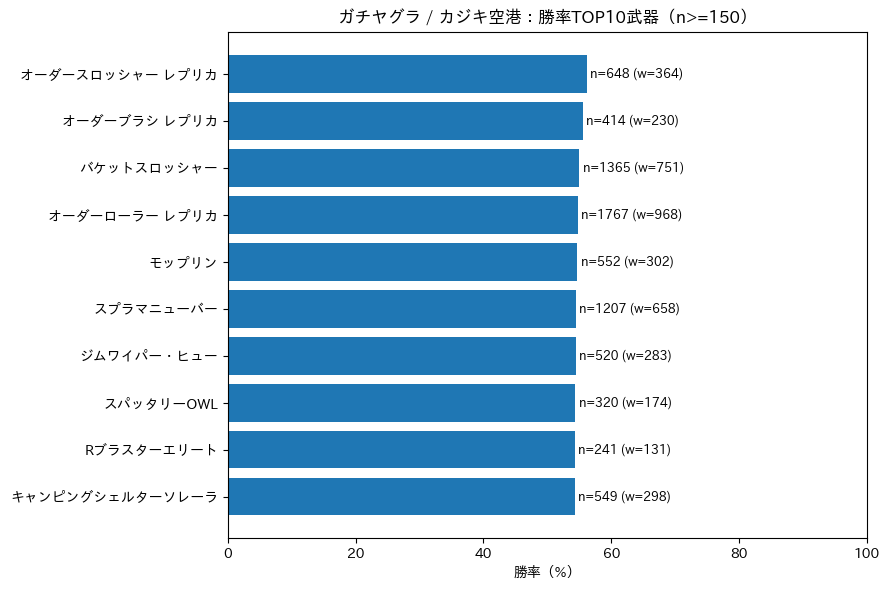

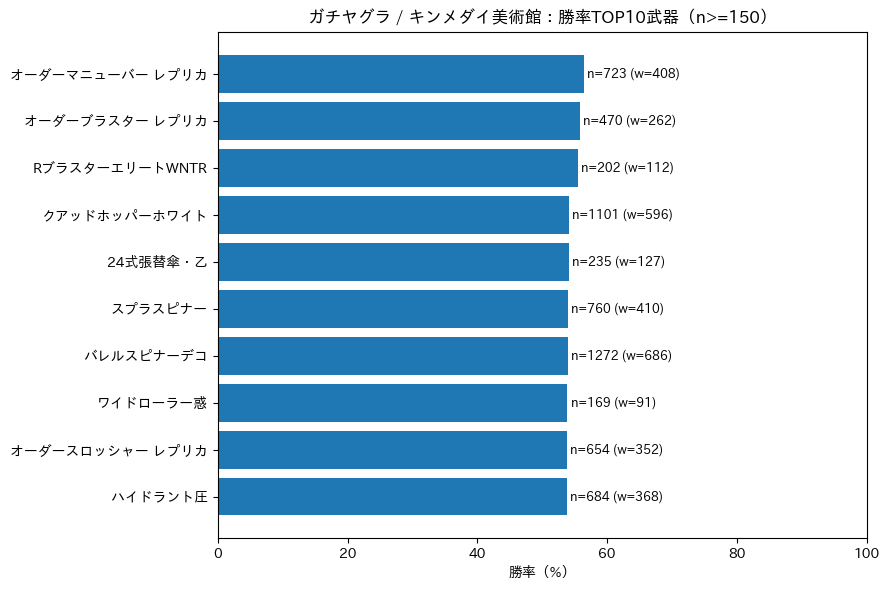

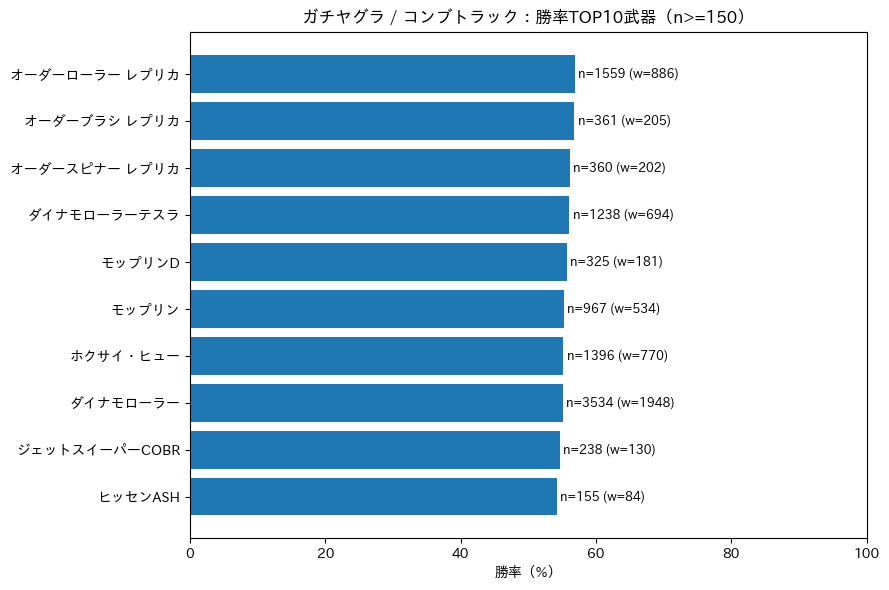

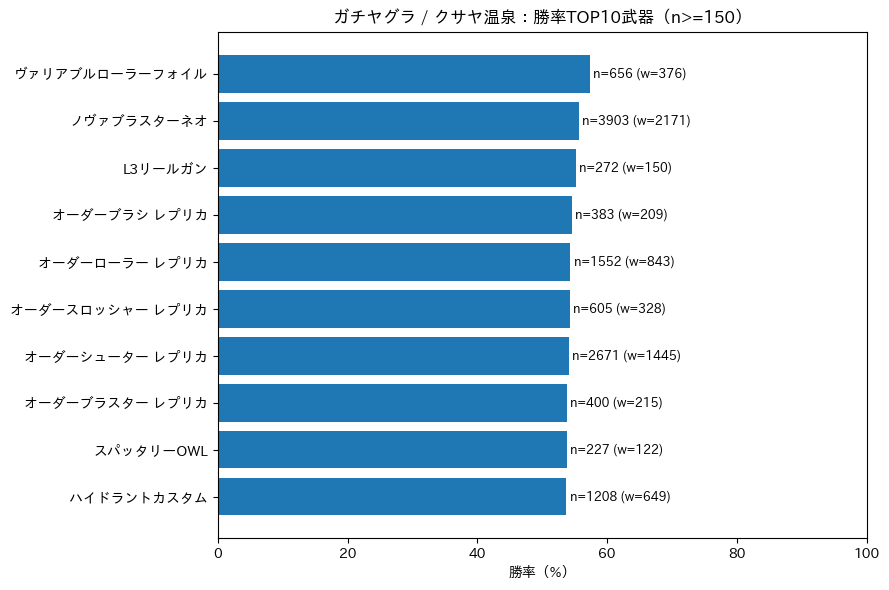

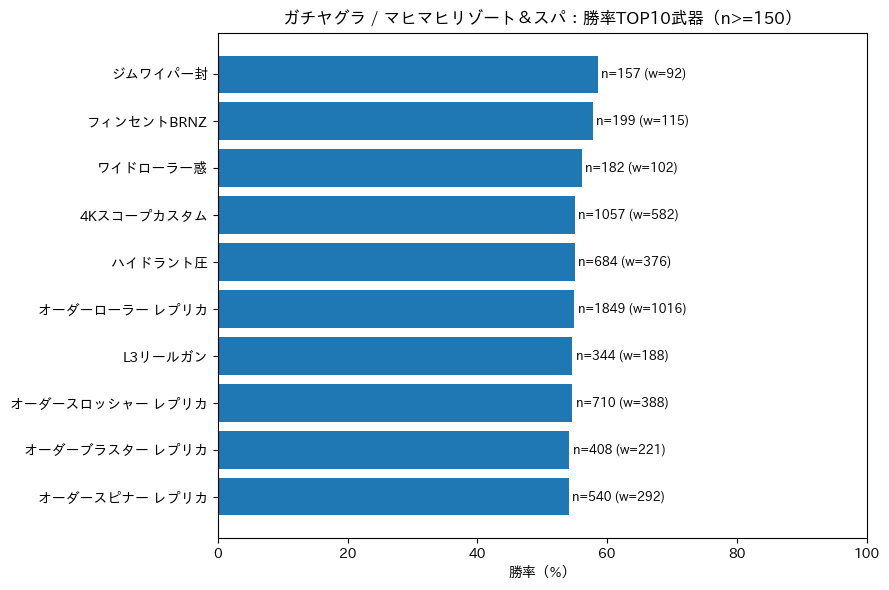

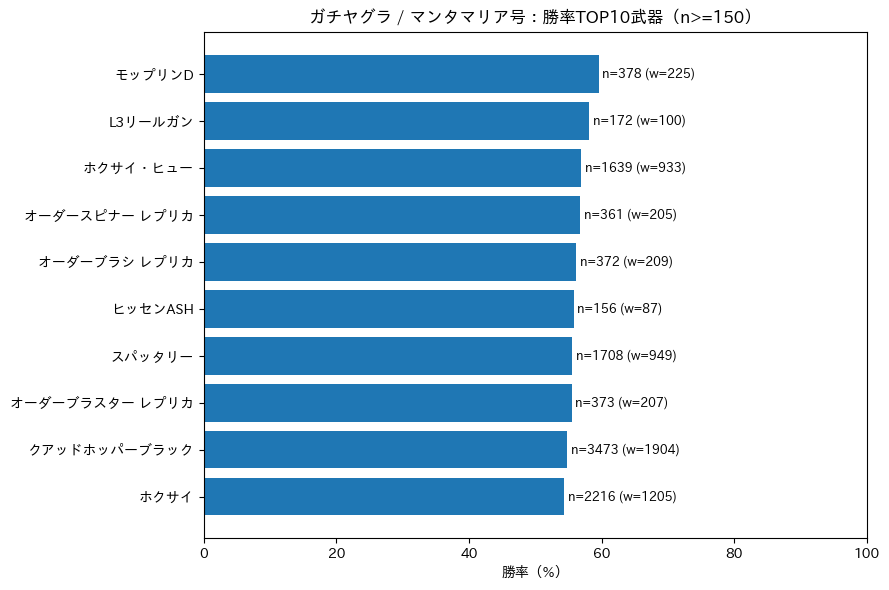

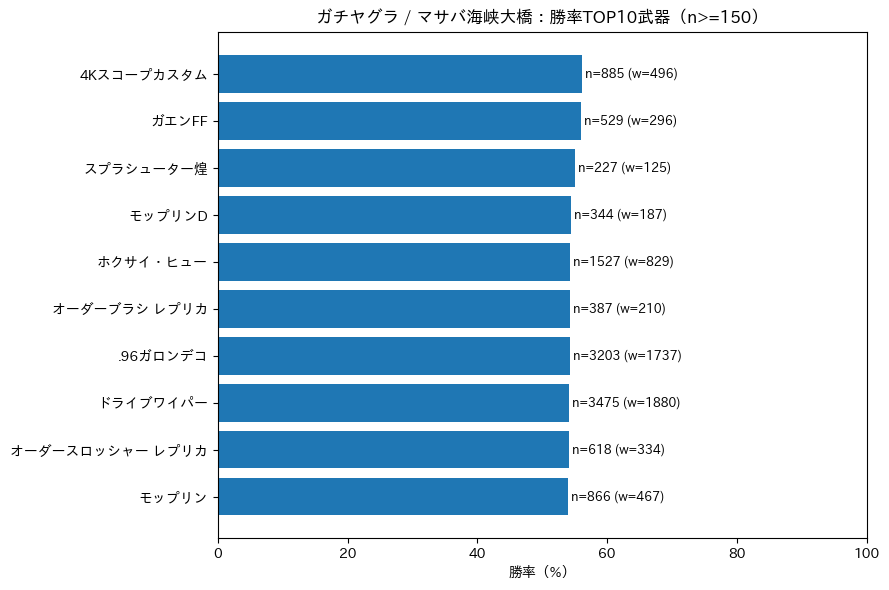

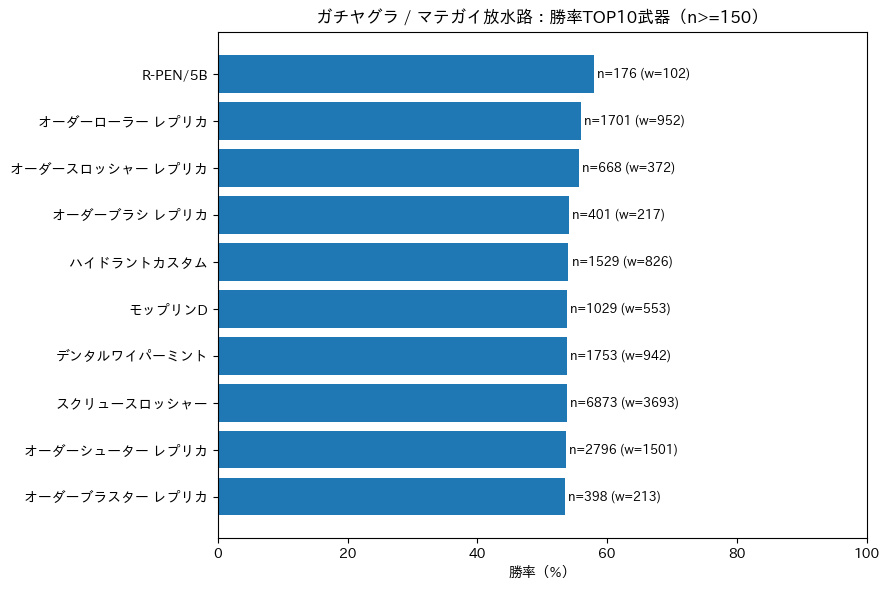

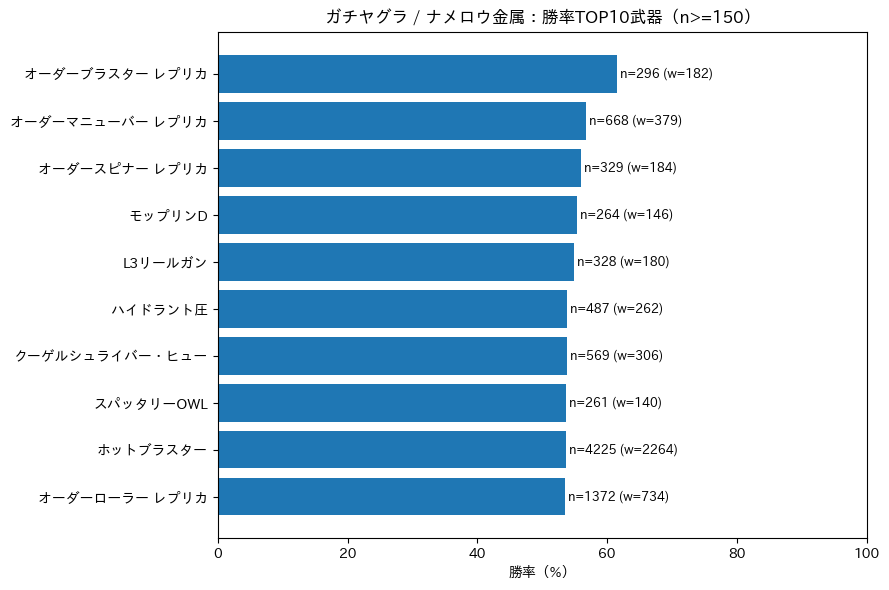

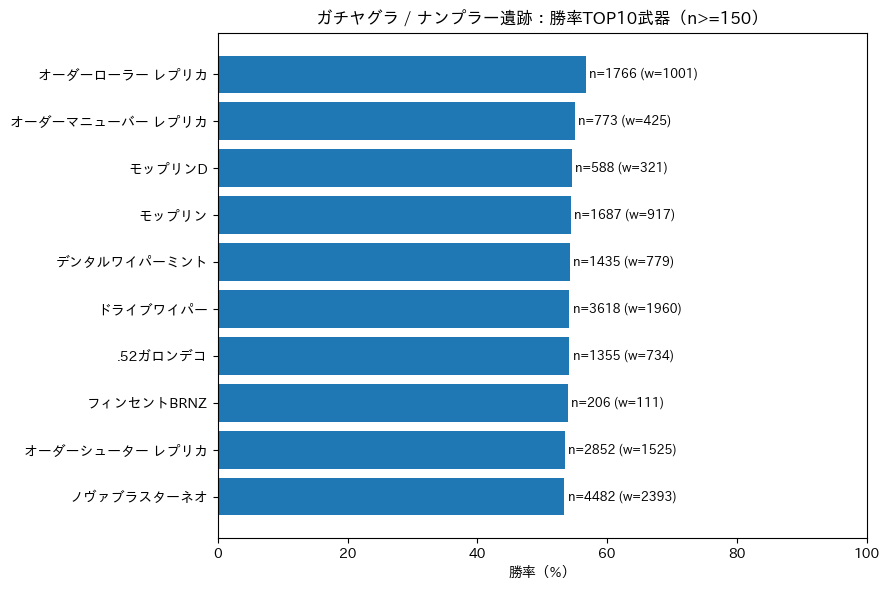

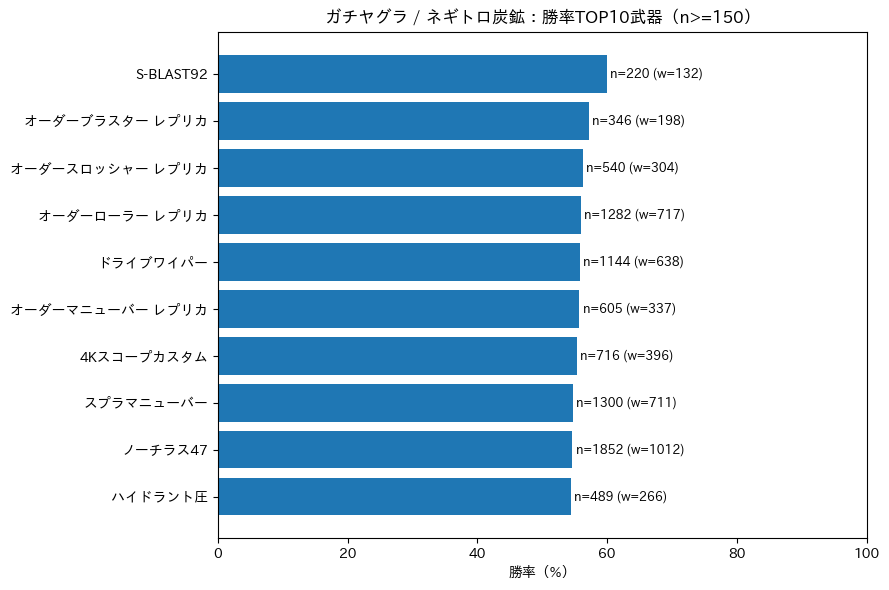

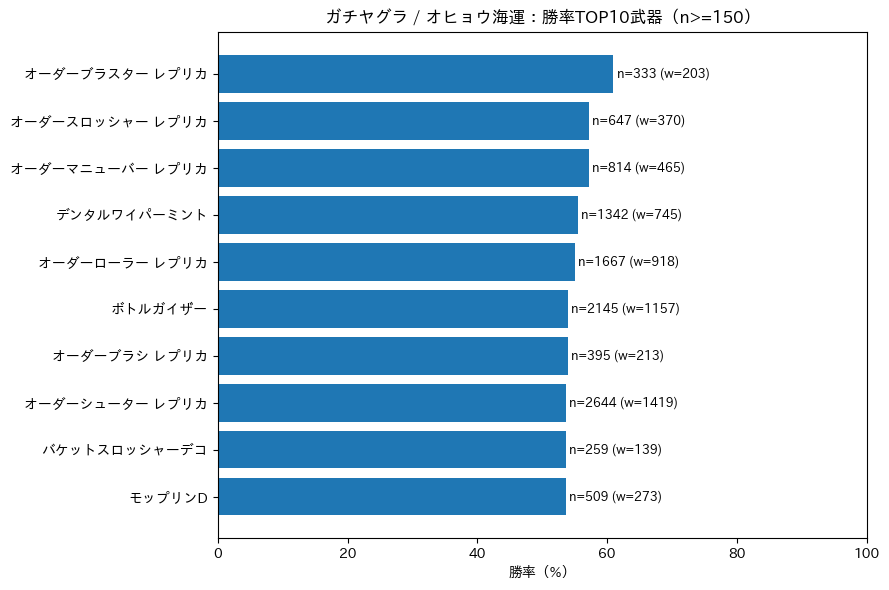

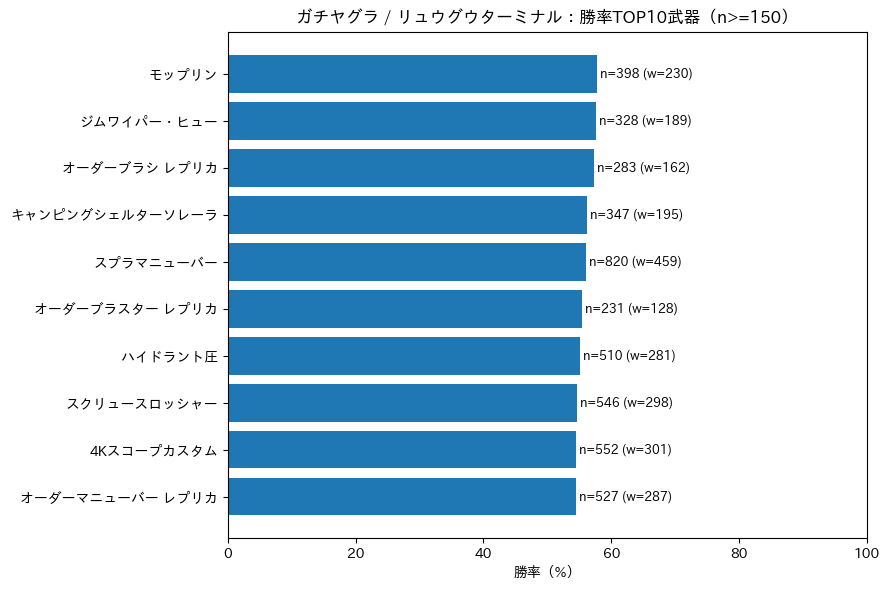

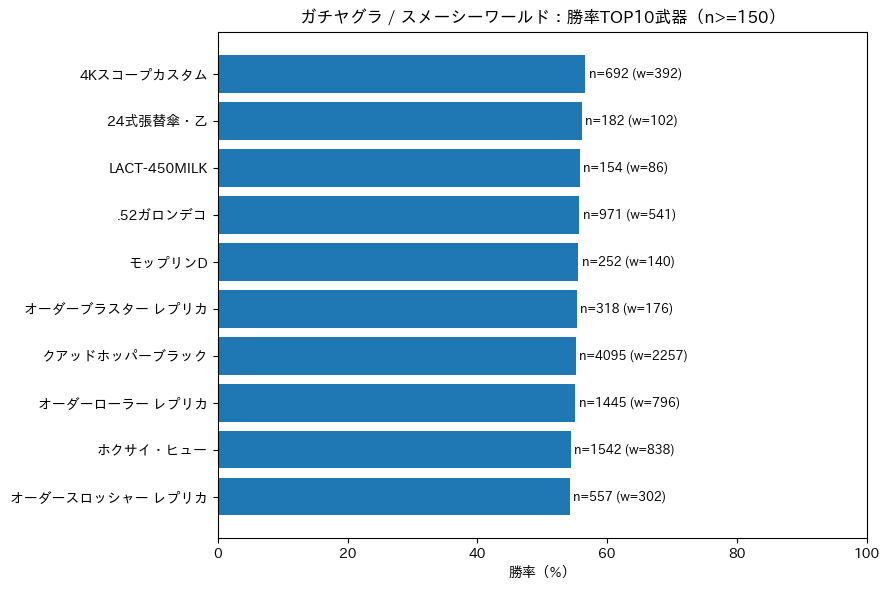

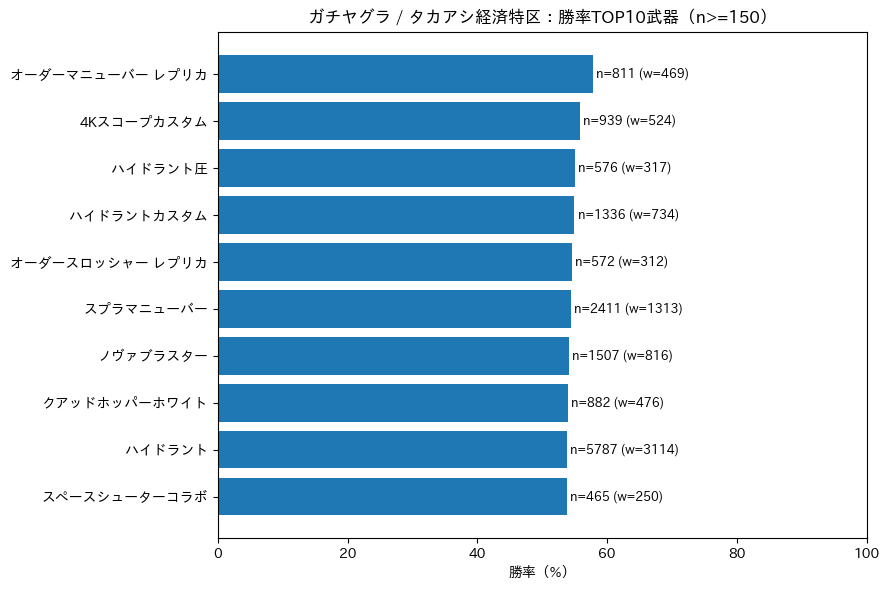

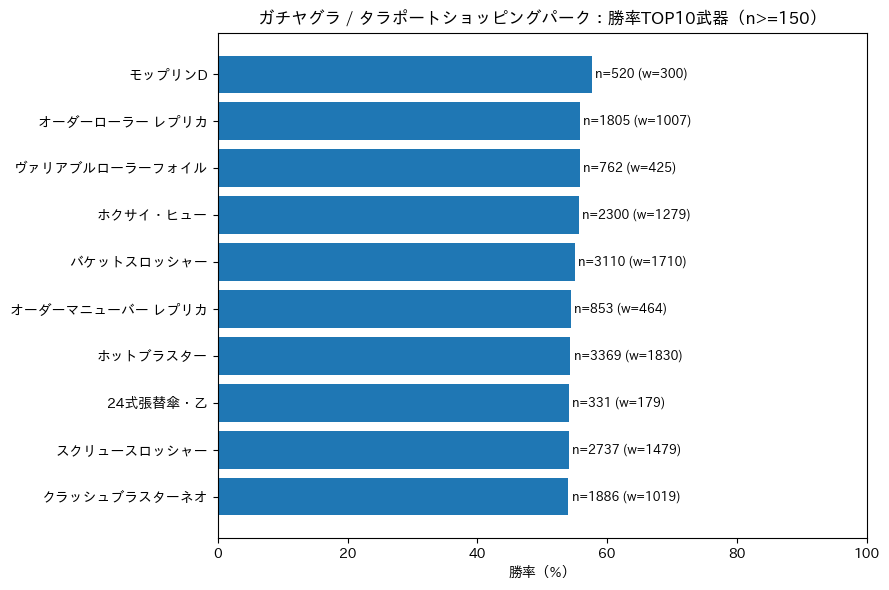

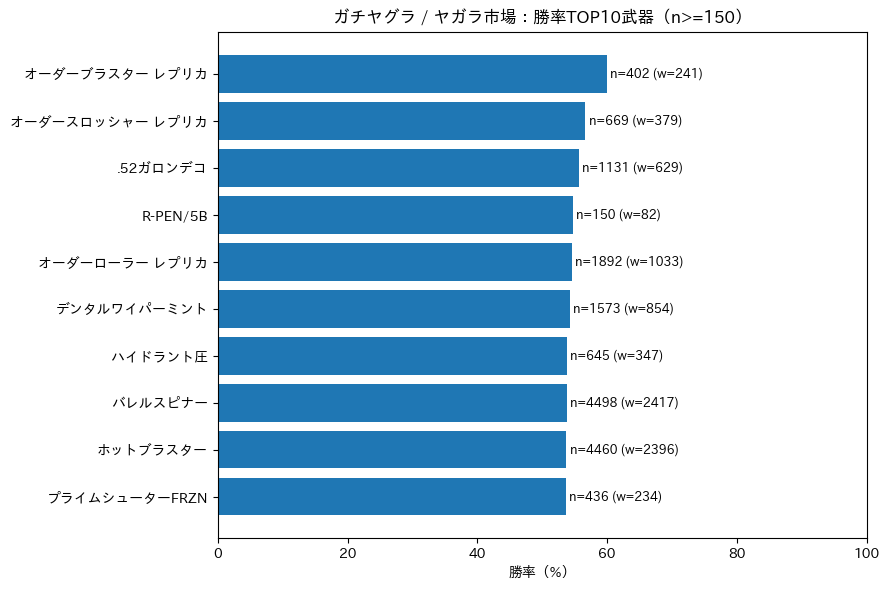

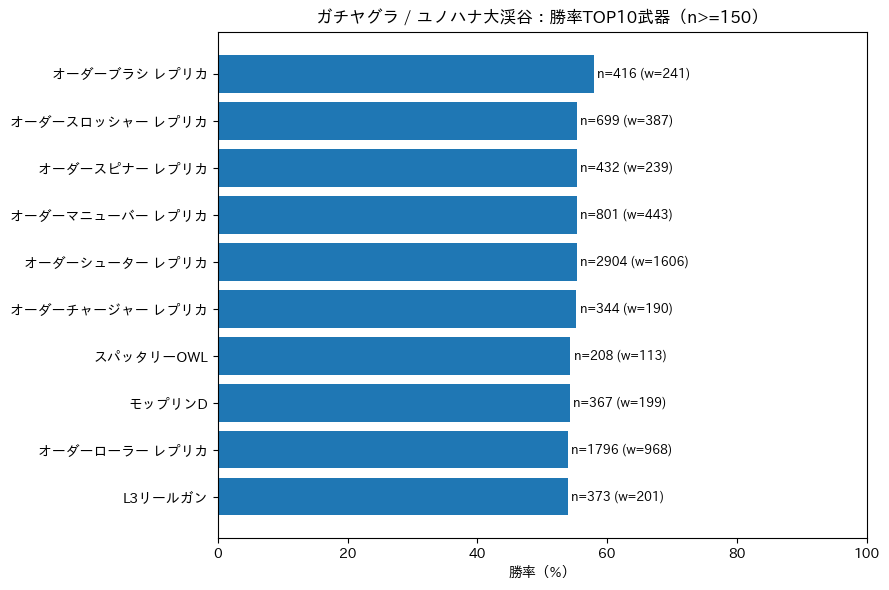

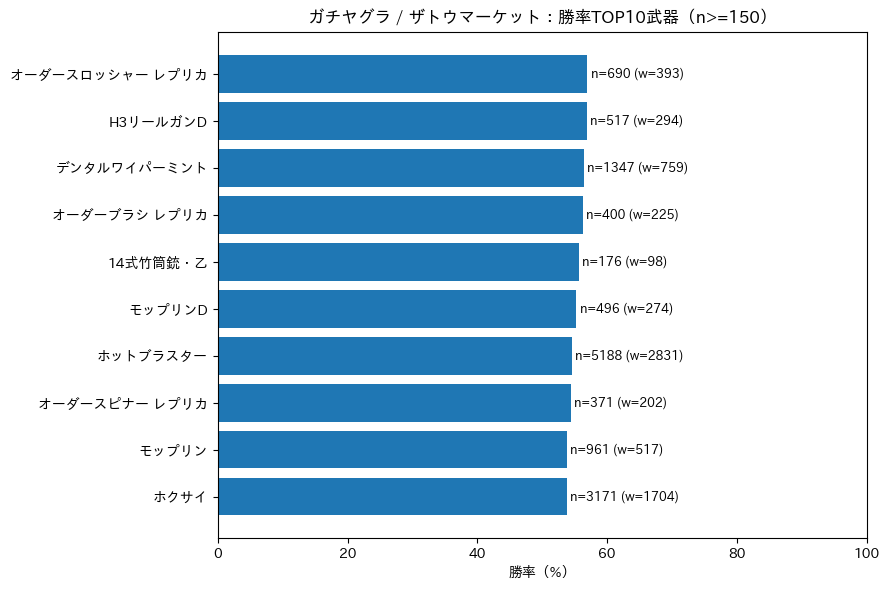

保存完了: /Users/itokouta/Desktop/02.プログラミング/分析系/04_Splatoon_Analytics/Analytics_output


In [12]:
from pathlib import Path
import re
import polars as pl
import matplotlib.pyplot as plt

MIN_GAMES = 150   # 試合数が150以上を分析に使用
TOP_K = 10        # TOP10

MODE_JA = {
    "nawabari": "ナワバリ",
    "area": "ガチエリア",
    "yagura": "ガチヤグラ",
    "hoko": "ガチホコ",
    "asari": "ガチアサリ",
}

OUT_ROOT = Path("Analytics_output")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

def safe_filename(name: str) -> str:
    name = str(name).strip().replace("\n", " ")
    return re.sub(r'[\\/:*?"<>|]+', "_", name)

# 勝ちフラグ（team == win）
df2 = df.with_columns(
    (pl.col("team") == pl.col("win")).cast(pl.Int32).alias("is_win")
)

# ルール×ステージ×武器で勝率集計
agg = (
    df2.group_by(["mode", "stage", "weapon"])
       .agg(
           pl.len().alias("games"),
           pl.sum("is_win").alias("wins"),
       )
       .with_columns((pl.col("wins") / pl.col("games")).alias("win_rate"))
       .filter(pl.col("games") >= MIN_GAMES)
)

# 日本語名カラム追加（辞書に無ければ元値）
agg = agg.with_columns([
    pl.coalesce([pl.col("stage").replace(stage_ja), pl.col("stage")]).alias("stage_ja"),
    pl.coalesce([pl.col("weapon").replace(weapon_ja), pl.col("weapon")]).alias("weapon_ja"),
])

# mode×stage ごとに TOP_K 抽出
top = (
    agg.sort(["mode", "stage", "win_rate", "games"], descending=[False, False, True, True])
       .group_by(["mode", "stage"])
       .head(TOP_K)
)

modes = sorted(top.select("mode").unique().to_series().to_list())

SHOW_PLOTS = True

for mode in modes:
    mode_name = MODE_JA.get(mode, mode)

    mode_dir = OUT_ROOT / safe_filename(mode_name)
    mode_dir.mkdir(parents=True, exist_ok=True)

    mode_df = top.filter(pl.col("mode") == mode)
    stages = sorted(mode_df.select("stage").unique().to_series().to_list())

    for stage in stages:
        s_df = (
            mode_df.filter(pl.col("stage") == stage)
                   .sort(["win_rate", "games"], descending=[True, True])
        )

        rows = s_df.select(["weapon_ja", "win_rate", "games", "wins", "stage_ja"]).to_dicts()
        if not rows:
            continue

        stage_name = rows[0]["stage_ja"]

        labels = [r["weapon_ja"] for r in rows][::-1]
        values = [r["win_rate"] * 100 for r in rows][::-1]
        annots = [f"n={int(r['games'])} (w={int(r['wins'])})" for r in rows][::-1]

        fig, ax = plt.subplots(figsize=(9, max(3.5, 0.6 * len(labels))))
        ax.barh(labels, values)
        ax.set_title(f"{mode_name} / {stage_name}：勝率TOP{TOP_K}武器（n>={MIN_GAMES}）")
        ax.set_xlabel("勝率（%）")
        ax.set_xlim(0, 100)

        for i, (x, a) in enumerate(zip(values, annots)):
            ax.text(x + 0.5, i, a, va="center", fontsize=9)

        plt.tight_layout()

        out_path = mode_dir / f"{safe_filename(stage_name)}_top{TOP_K}_n{MIN_GAMES}.png"
        fig.savefig(out_path, dpi=200)

        if SHOW_PLOTS:
            plt.show()

        plt.close(fig)

print(f"保存完了: {OUT_ROOT.resolve()}")
